## Import statements

In [2]:
library(BBmisc)
library(bnlearn)
library(penalized)


Attaching package: 'bnlearn'

The following object is masked from 'package:stats':

    sigma

Loading required package: survival
Welcome to penalized. For extended examples, see vignette("penalized").


## 1. Function to input datasets

In [165]:
read_data <- function(unitname, filename, normalize=TRUE){
    input <- read.delim(paste("C:/Users/abhig/OneDrive/Desktop/#MTP/data/data", filename, "_", unitname,".txt", sep=""))
    input$X <- NULL
    if(unitname == "mixer" || unitname == "reactor"){
        colnames(input)[4] = "R5"
    }
    if(unitname==""){
        input <- cbind(input,R5=rep(input$F5))
    }
    if(normalize){
        return (BBmisc::normalize(input))
    }
    else{
        return (input)
    }
}

## 2a. Function to plot the graph (given model)

In [157]:
plot_graph <- function(dag){
    par(cex=0.07)
    options(repr.plot.width=3, repr.plot.height=3)
    hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "black", textCol = "black", fill ='lightblue', lwd = 2)
    graphviz.plot(dag, highlight = hlight)    
}

## 2b. Function to plot a graph-comparison between two models

In [158]:
compare_graph <- function(dag1, dag2){
    message("True Positive   : BLACK arcs")
    message("False Positive  : BLUE arcs")
    message("False Negaitive : RED arcs")
    par(cex=0.08)
    options(repr.plot.width=3, repr.plot.height=3)
    hlight <- list(tp.col = "black", tp.lty = 1, tp.lwd =2, fp.col = "deepskyblue", fp.lty = 5, fp.lwd =2, fn.col = "red", fn.lty = 2, fn.lwd =2)
    graphviz.compare(dag1, dag2, diff="from-first", diff.args = hlight)
}

## 2c. Function to compare two models across various metrics

In [159]:
compare_models <- function(dag1, dag2, verbose=TRUE){
    res = compare(dag2, dag1, arcs = FALSE)
    TP = res$tp
    FP = res$fp
    FN = res$fn
    Recall = TP/ (TP+FN)
    Precision = TP/ (TP+FP)
    F1 = 2*TP/ (2*TP + FP + FN)
    if(verbose){
        print(paste("True Positive          = ", TP))
        print(paste("False Positive         = ", FP))
        print(paste("False Negative         = ", FN))
        print(paste("Recall (sensitivity)   = ", Recall))
        print(paste("Precision              = ", Precision))
        print(paste("F1 score               = ", F1))
#         cat("\n")
#         print("The corresponding 'to' and 'from' arcs are: ")
#         print(compare(mixer_rnd1, mixer, arcs = TRUE))
    }
    return(F1)
}

## 3. Function to fit linear gaussian model

In [160]:
gaussian <- function(dag, data, verbose=FALSE){  
    print(modelstring(dag))
    est.para <- bn.fit(dag, data)
    if(verbose){
        print(est.para)
    }
    return(est.para)
}
#     est.para$F6 <- penalized(F6 ~ F1 + F2 + F3 + F5, lambda1 = 2, lambda2 = 1.5, data = data_mixer)
#     est.para$F6

## 4. Function to calculate score

In [161]:
graph_score <- function(dag, data, verbose=TRUE) {
    loglik <- bnlearn::score(dag, data, type = "loglik-g")
    aic <- bnlearn::score(dag, data, type = "aic-g")
    bic <- bnlearn::score(dag, data, type = "bic-g")
    bge <- bnlearn::score(dag, data, type = "bge")
    if(verbose){
        print(paste("The multivariate Gaussian log-likelihood score         = ", loglik))
        print(paste("The corresponding Akaike Information Criterion score   = ", aic))
        print(paste("The corresponding Bayesian Information Criterion score = ", bic))
        print(paste("A score equivalent Gaussian posterior density          = ", bge))
        cat("\n")
    }
    return(data.frame(loglik, aic, bic, bge))
}

## 5. Function to compare scores across 3 configurations and 4 datasets

In [178]:
compare_scores <- function(dag0, dag1, dag2, unitname){
    data_1a <- read_data(unitname, "1a")
    data_1d <- read_data(unitname, "1d")
    data_3a <- read_data(unitname, "3a")
    data_3d <- read_data(unitname, "3d")
    
    score0 <- graph_score(dag0, data = data_1a, FALSE)
    score1 <- graph_score(dag1, data = data_1a, FALSE)
    score2 <- graph_score(dag2, data = data_1a, FALSE)
    score1a <- rbind(score0, score1, score2)

    score0 <- graph_score(dag0, data = data_1d, FALSE)
    score1 <- graph_score(dag1, data = data_1d, FALSE)
    score2 <- graph_score(dag2, data = data_1d, FALSE)
    score1d <- rbind(score0, score1, score2)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score2 <- graph_score(dag2, data = data_3a, FALSE)
    score3a <- rbind(score0, score1, score2)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score2 <- graph_score(dag2, data = data_3a, FALSE)
    score3d <- rbind(score0, score1, score2)
    
    return(cbind(score1a, score1d, score3a, score3d))    
}

In [180]:
compare_scores_2 <- function(dag0, dag1, unitname){
    data_1a <- read_data(unitname, "1a")
    data_1d <- read_data(unitname, "1d")
    data_3a <- read_data(unitname, "3a")
    data_3d <- read_data(unitname, "3d")
    
    score0 <- graph_score(dag0, data = data_1a, FALSE)
    score1 <- graph_score(dag1, data = data_1a, FALSE)
    score1a <- rbind(score0, score1 )

    score0 <- graph_score(dag0, data = data_1d, FALSE)
    score1 <- graph_score(dag1, data = data_1d, FALSE)
    score1d <- rbind(score0, score1)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score3a <- rbind(score0, score1)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score3d <- rbind(score0, score1)
    
    return(cbind(score1a, score1d, score3a, score3d))    
}

## 6. Function to learn structure using hill climbing approach (score based)

In [206]:
learn_structure <- function(true_dag, unitname, filename){ 
    
    dataset <- read_data(unitname, filename)
    
    stru1 <- bnlearn::hc(dataset, score = "aic-g", start = random.graph(names(dataset)))
    plot_graph(stru1)
    compare_graph(true_dag, stru1)
    message(paste("score = AIC, dataset =" , filename))
    aic = compare_models(true_dag, stru1, TRUE)
    
    stru2 <- bnlearn::hc(dataset, score = "bic-g", start = random.graph(names(dataset)))
    plot_graph(stru2)
    compare_graph(true_dag, stru2)
    message(paste("score = BIC, dataset =" , filename))
    bic = compare_models(true_dag, stru2, TRUE)
    
    stru3 <- bnlearn::hc(dataset, score = "bge", start = random.graph(names(dataset)))
    plot_graph(stru3)
    compare_graph(true_dag, stru3)
    message(paste("score = BGE, dataset =" , filename))
    bge = compare_models(true_dag, stru3, TRUE)
    
    stru4 <- bnlearn::hc(dataset, score = "loglik-g", start = random.graph(names(dataset)))
    plot_graph(stru4)
    compare_graph(true_dag, stru4)
    message(paste("score = LOGLIKE, dataset =" , filename))
    loglike = compare_models(true_dag, stru4, TRUE)
    
    F1_measure = list("aic" = aic, "bic" = bic, "bge" = bge, "loglike" = loglike)
    return(F1_measure)
    
}    

<hr>

<span style="color:red"><font size="6"><b>7a. MIXER...</b></font></span>

### [Mixer] 3 configurations: 1 true and 2 randoms

In [194]:
mixer <- model2network("[F1][F2][F3][R5][F6|F1:F2:F3:R5]")
mixer_rnd1 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6"))
mixer_rnd2 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6"))

### [Mixer] Plotting graphs of all three configurations

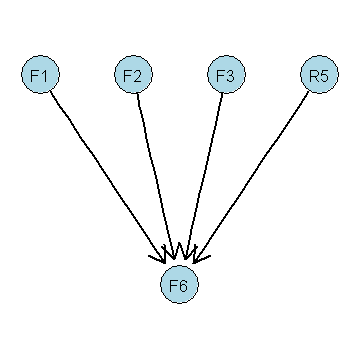

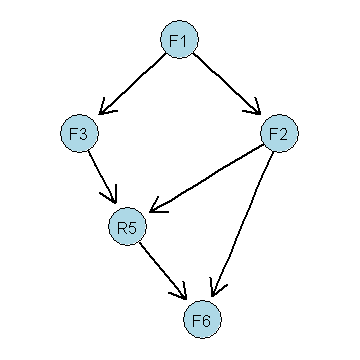

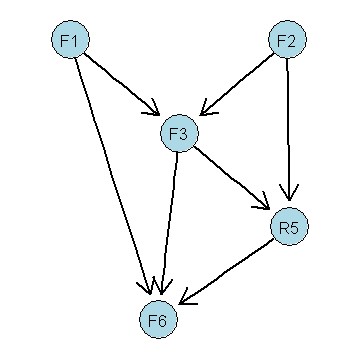

In [195]:
plot_graph(mixer)
plot_graph(mixer_rnd1)
plot_graph(mixer_rnd2)

### [Mixer] Comparing true graph 1 with true graph 2

[1] "True Positive          =  4"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


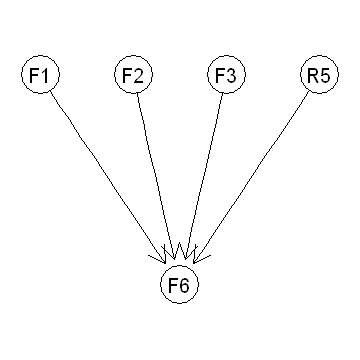

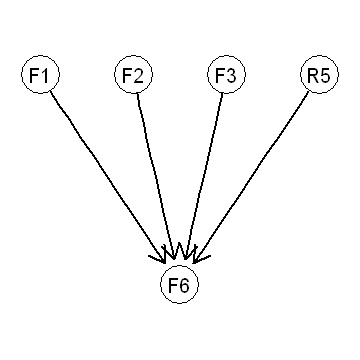

In [196]:
mixer1 <- model2network("[F1][F2][F3][R5][F6|F1:F2:F3:R5]")
garbage =compare_models(mixer, mixer1)
compare_graph(mixer1, mixer)

### [Mixer] Fitting each of the three into linear gaussian model.

In [197]:
gaussian_mixer <- gaussian(mixer, read_data("mixer", "1a"))
gaussian_mixer_rnd1 <- gaussian(mixer_rnd1, read_data("mixer", "1a"))
gaussian_mixer_rnd2 <- gaussian(mixer_rnd2, read_data("mixer", "1a"))

[1] "[F1][F2][F3][R5][F6|F1:F2:F3:R5]"
[1] "[F1][F2|F1][F3|F1][R5|F2:F3][F6|F2:R5]"
[1] "[F1][F2][F3|F1:F2][R5|F2:F3][F6|F1:F3:R5]"


### [Mixer] Comparing scores across 3 configurations and 4 datasets.

In [198]:
compare_scores(mixer, mixer_rnd1, mixer_rnd2, "mixer")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-7095.069,-7104.069,-7126.158,-7130.037,-7098.257,-7107.257,-7129.347,-7133.223,-7095.457,-7104.457,-7126.546,-7130.425,-7095.457,-7104.457,-7126.546,-7130.425
-7093.021,-7104.021,-7131.019,-7133.023,-7096.766,-7107.766,-7134.764,-7136.758,-7093.064,-7104.064,-7131.062,-7133.067,-7093.064,-7104.064,-7131.062,-7133.067
-7087.596,-7099.596,-7129.049,-7130.349,-7093.083,-7105.083,-7134.536,-7135.823,-7077.208,-7089.208,-7118.661,-7119.990,-7077.208,-7089.208,-7118.661,-7119.990


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Mixer] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


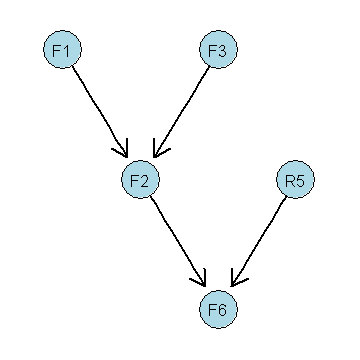

score = AIC, dataset = 1a


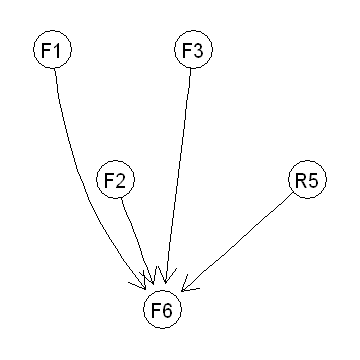

[1] "True Positive          =  2"
[1] "False Positive         =  2"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.5"
[1] "F1 score               =  0.5"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


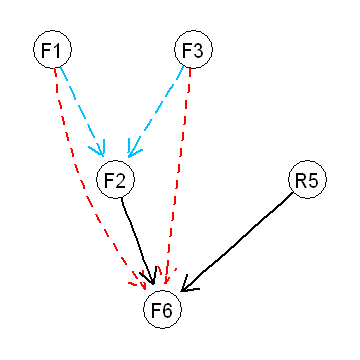

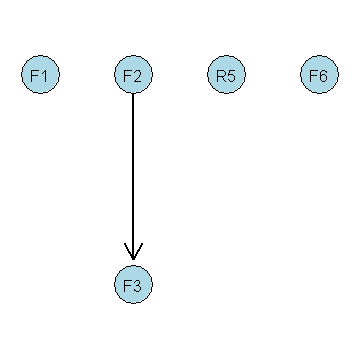

score = BIC, dataset = 1a


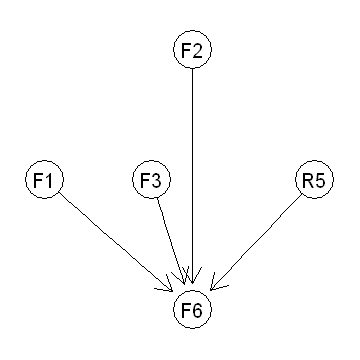

[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


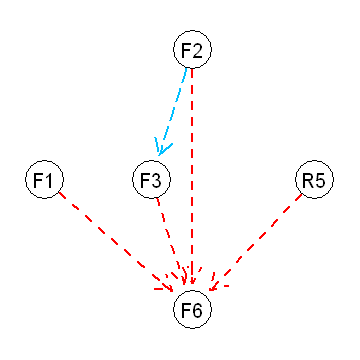

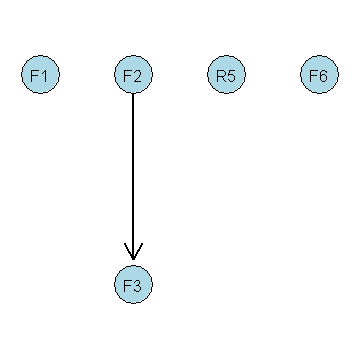

score = BGE, dataset = 1a


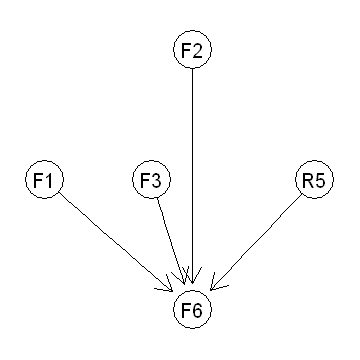

[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


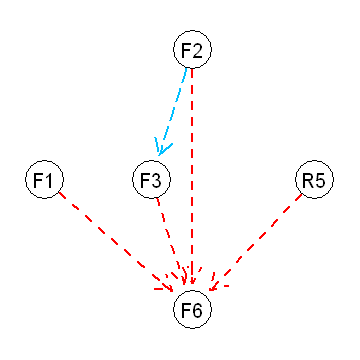

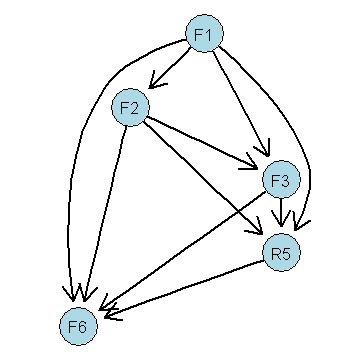

score = LOGLIKE, dataset = 1a


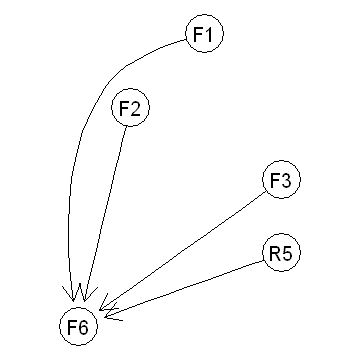

[1] "True Positive          =  4"
[1] "False Positive         =  0"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.4"
[1] "Precision              =  1"
[1] "F1 score               =  0.571428571428571"


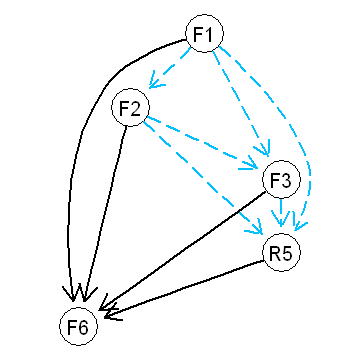

In [209]:
score1a = learn_structure(mixer, "mixer", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


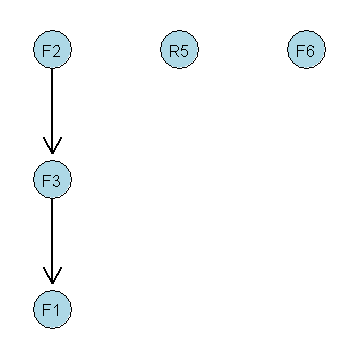

score = AIC, dataset = 1d
Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."

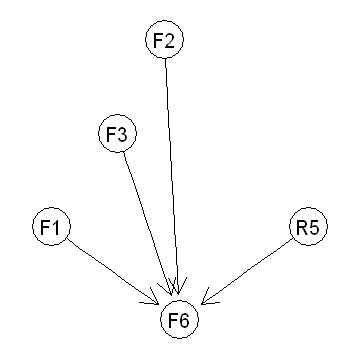

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


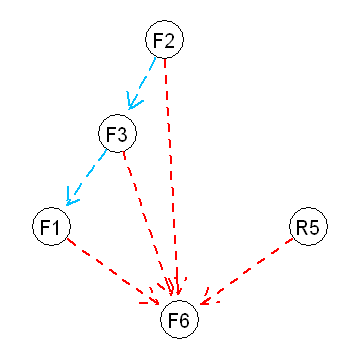

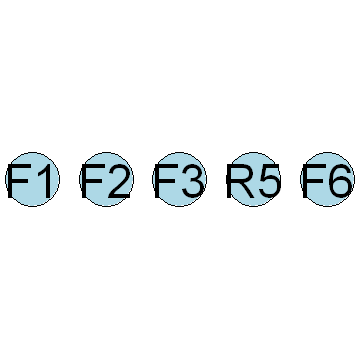

score = BIC, dataset = 1d


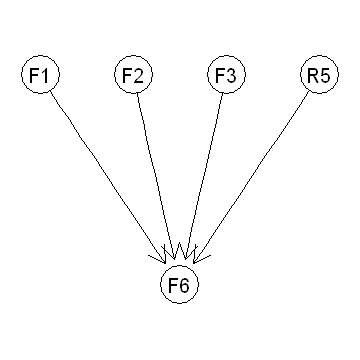

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


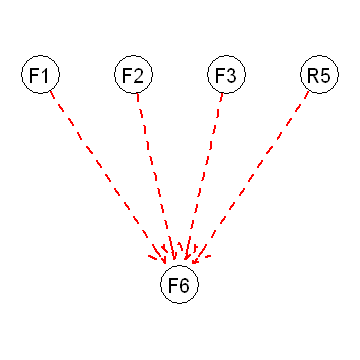

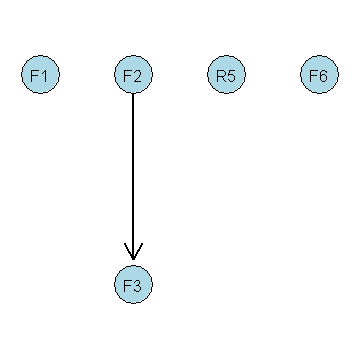

score = BGE, dataset = 1d


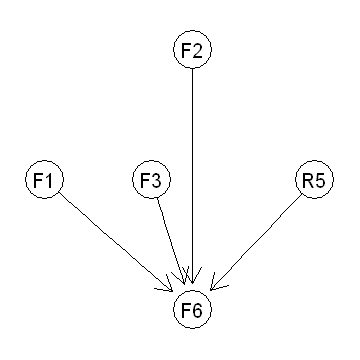

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


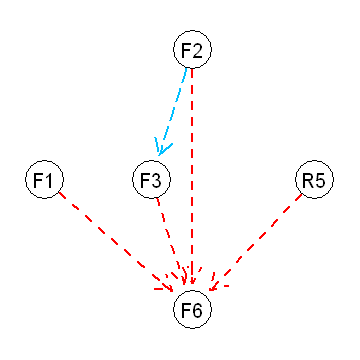

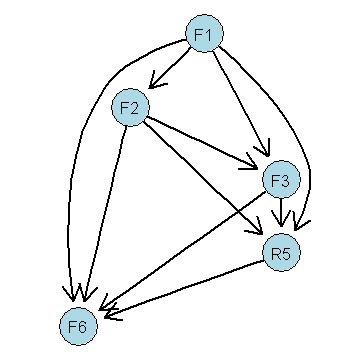

score = LOGLIKE, dataset = 1d


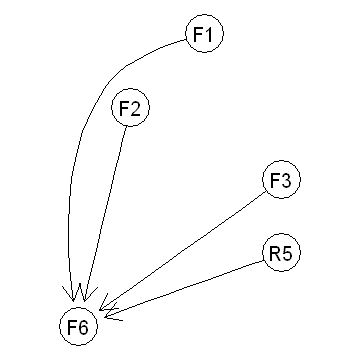

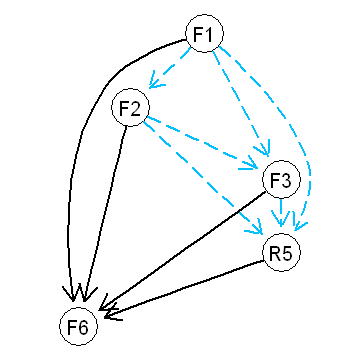

In [202]:
score1d = learn_structure(mixer, "mixer", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


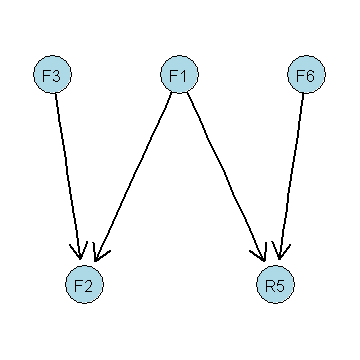

score = AIC, dataset = 3a


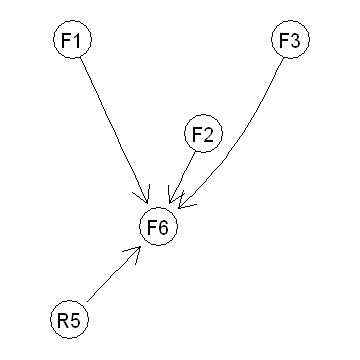

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


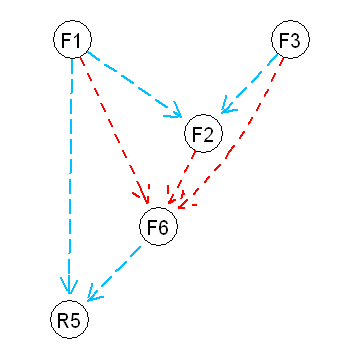

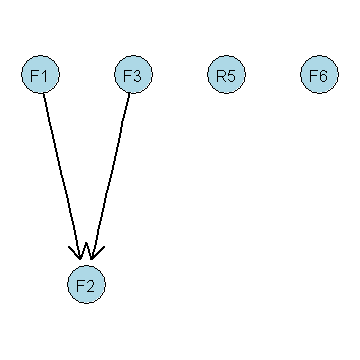

score = BIC, dataset = 3a


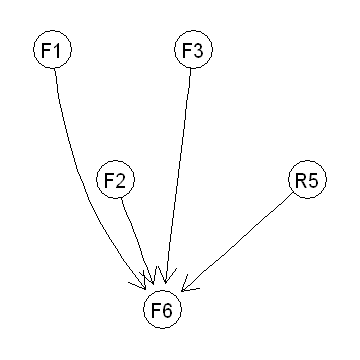

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


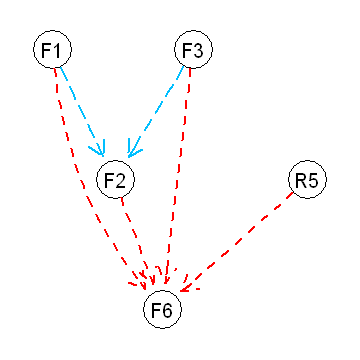

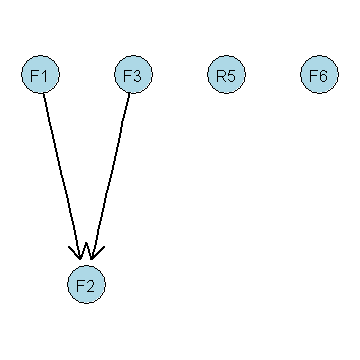

score = BGE, dataset = 3a


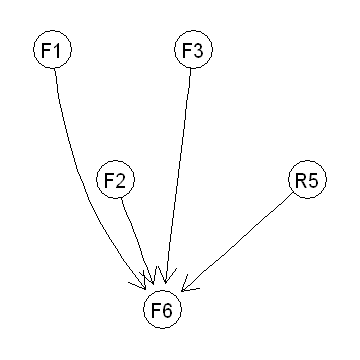

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


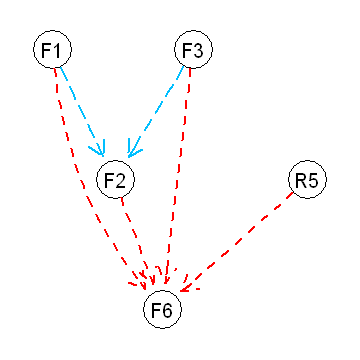

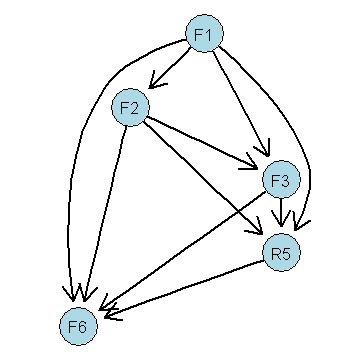

score = LOGLIKE, dataset = 3a


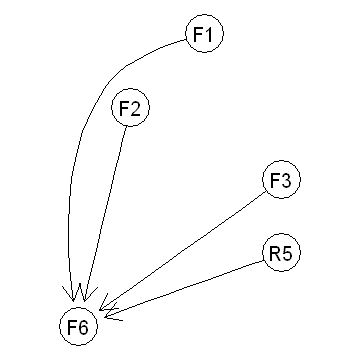

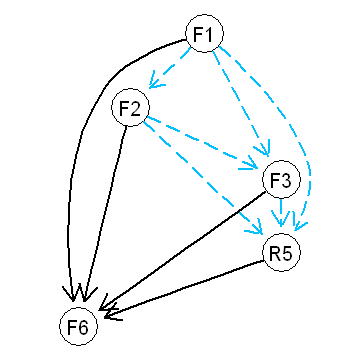

In [203]:
score3a = learn_structure(mixer, "mixer", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


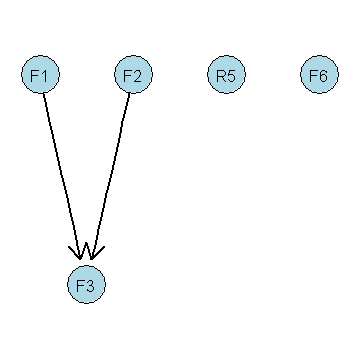

score = AIC, dataset = 3d


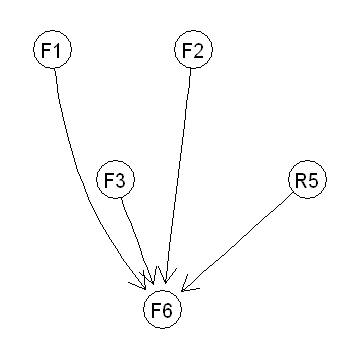

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


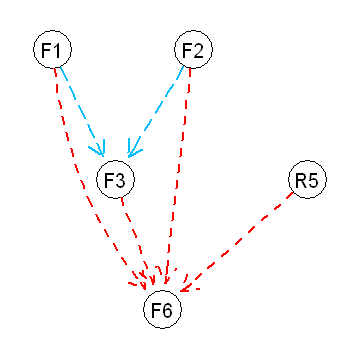

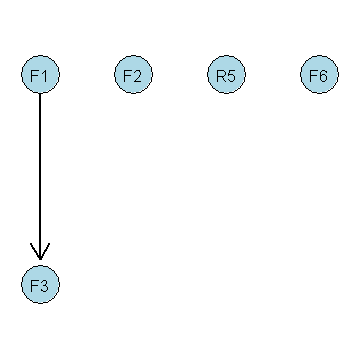

score = BIC, dataset = 3d


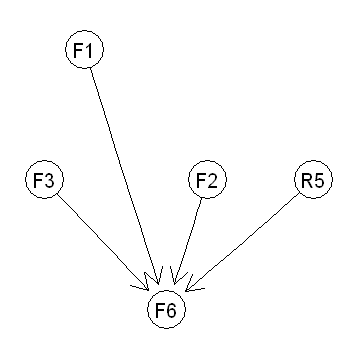

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


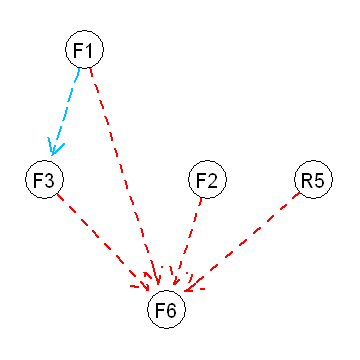

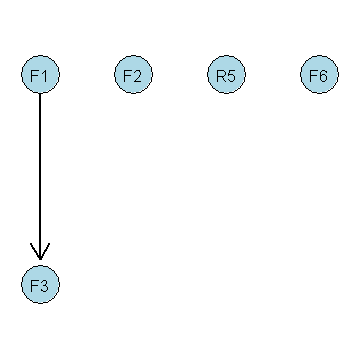

score = BGE, dataset = 3d


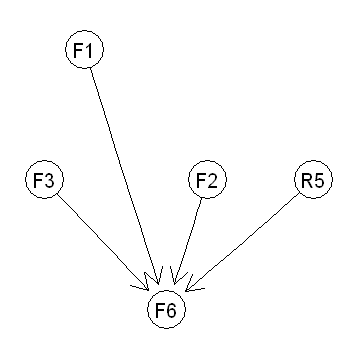

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


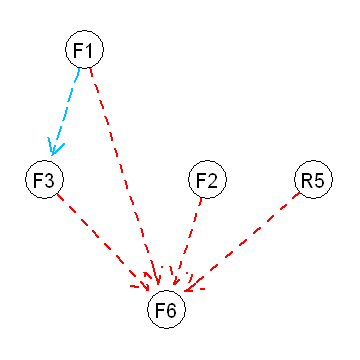

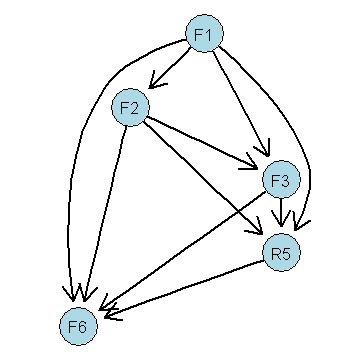

score = LOGLIKE, dataset = 3d


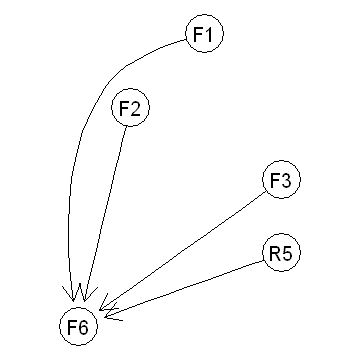

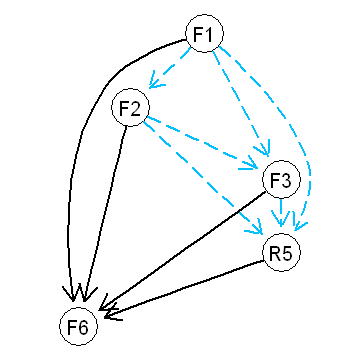

In [204]:
score3d = learn_structure(mixer, "mixer", "3d")

### [Mixer] Comparison of F1 scores across various score-based methods and datasets

In [205]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge,loglike
score1a,0.5,0,0,0.5714286
score1d,0,0,0,0.5714286
score3a,0,0,0,0.5714286
score3d,0,0,0,0.5714286


<hr>

<span style="color:red"><font size="6"><b>7b. REACTOR...</b></font></span>

### [Reactor] 3 configurations: 1 true and 2 randoms

In [67]:
reactor <- model2network("[F1][F2][F3][R5][T21|F1:F6:R5:F3][T9|R5:F6:T21][P7|F1:R5:F6:L8:T9:T21][L8|F1:F2:R5:F6:T21][F6|F1:F2:F3:R5]")
reactor_rnd1 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7"))
reactor_rnd2 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7"))

### [Reactor] Plotting graphs of all three configurations

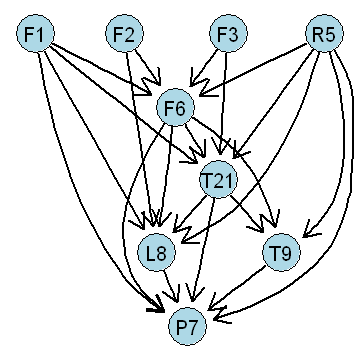

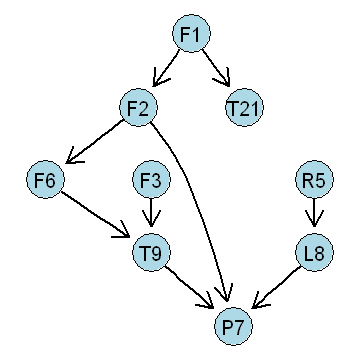

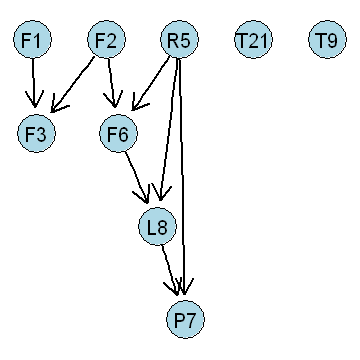

In [68]:
plot_graph(reactor)
plot_graph(reactor_rnd1)
plot_graph(reactor_rnd2)

### [Reactor] Comparing true graph 1 with true graph 2

[1] "True Positive          =  6"
[1] "False Positive         =  16"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.666666666666667"
[1] "Precision              =  0.272727272727273"
[1] "F1 score               =  0.387096774193548"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


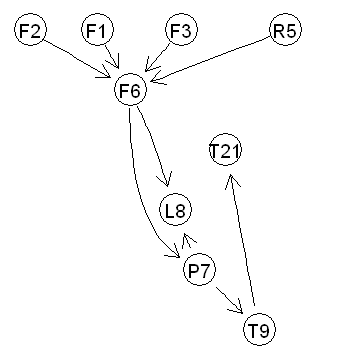

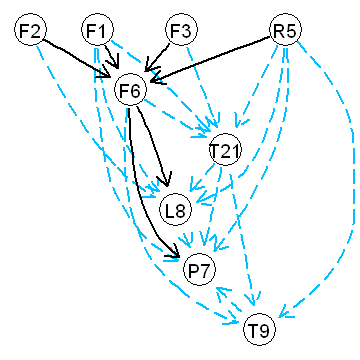

In [69]:
reactor1 = model2network("[F1][F2][F3][R5][T21|T9][T9|P7][P7|F6][L8|F6:P7][F6|F1:F2:F3:R5]")
garbage = compare_models(reactor, reactor1)
compare_graph(reactor1, reactor)

### [Reactor] Fitting each of the three into linear gaussian model.

In [72]:
gaussian_reactor <- gaussian(reactor, read_data("reactor", "1a"))
gaussian_reactor_rnd1 <- gaussian(reactor_rnd1, read_data("reactor", "1a"))
gaussian_reactor_rnd2 <- gaussian(reactor_rnd2, read_data("reactor", "1a"))

[1] "[F1][F2][F3][R5][F6|F1:F2:F3:R5][T21|F1:F3:F6:R5][L8|F1:F2:F6:R5:T21][T9|F6:R5:T21][P7|F1:F6:L8:R5:T21:T9]"
[1] "[F1][F3][R5][F2|F1][T21|F1][L8|R5][F6|F2][T9|F3:F6][P7|F2:T9:L8]"
[1] "[F1][F2][R5][T21][T9][F3|F1:F2][F6|F2:R5][L8|R5:F6][P7|R5:L8]"


### [Reactor] Comparing scores across 3 configurations and 4 datasets.

In [73]:
compare_scores(reactor, reactor_rnd1, reactor_rnd2, "reactor")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-12700.61,-12731.61,-12807.69,-12803.32,-12669.34,-12700.34,-12776.42,-12772.05,-12674.05,-12705.05,-12781.13,-12776.79,-12674.05,-12705.05,-12781.13,-12776.79
-12767.64,-12785.64,-12829.82,-12834.97,-12758.05,-12776.05,-12820.23,-12825.41,-12765.11,-12783.11,-12827.29,-12832.46,-12765.11,-12783.11,-12827.29,-12832.46
-12760.49,-12777.49,-12819.22,-12825.26,-12764.49,-12781.49,-12823.21,-12829.24,-12755.61,-12772.61,-12814.34,-12820.39,-12755.61,-12772.61,-12814.34,-12820.39


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Reactor] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


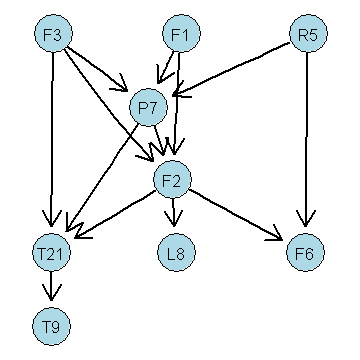

score = AIC, dataset = 1a


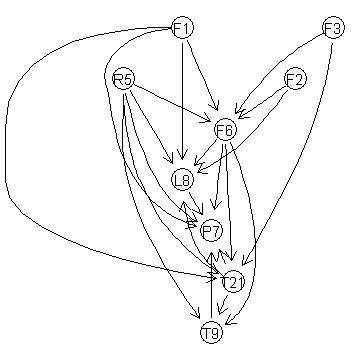

[1] "True Positive          =  7"
[1] "False Positive         =  15"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.538461538461538"
[1] "Precision              =  0.318181818181818"
[1] "F1 score               =  0.4"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


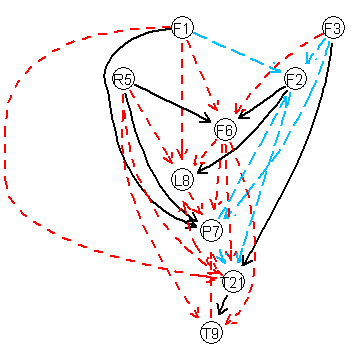

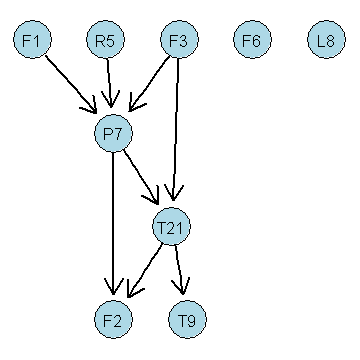

score = BIC, dataset = 1a


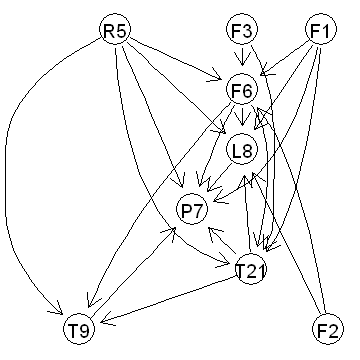

[1] "True Positive          =  4"
[1] "False Positive         =  18"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.181818181818182"
[1] "F1 score               =  0.266666666666667"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


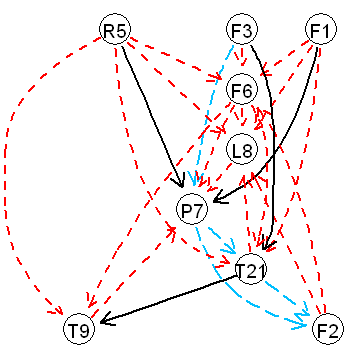

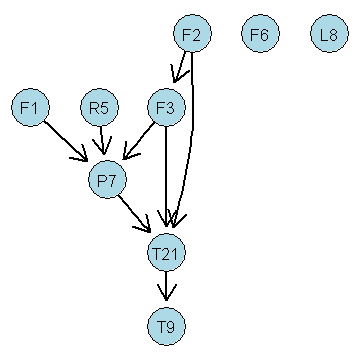

score = BGE, dataset = 1a


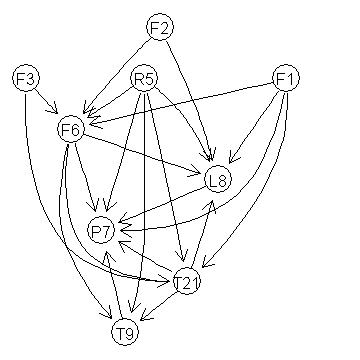

[1] "True Positive          =  4"
[1] "False Positive         =  18"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.181818181818182"
[1] "F1 score               =  0.266666666666667"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


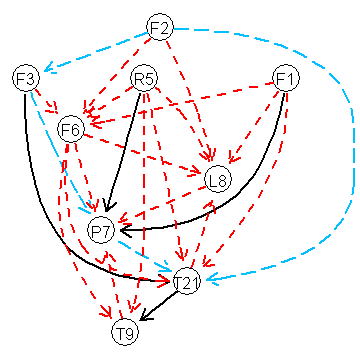

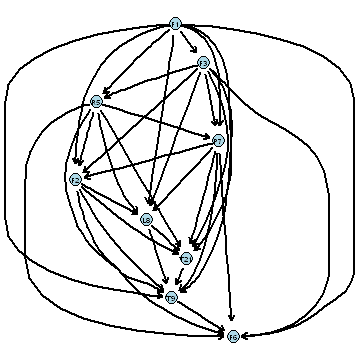

score = LOGLIKE, dataset = 1a


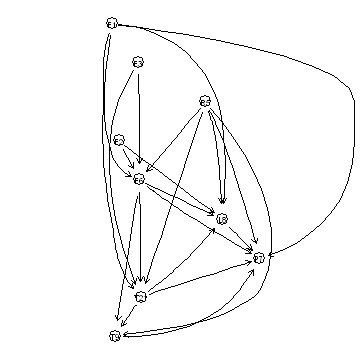

[1] "True Positive          =  14"
[1] "False Positive         =  8"
[1] "False Negative         =  20"
[1] "Recall (sensitivity)   =  0.411764705882353"
[1] "Precision              =  0.636363636363636"
[1] "F1 score               =  0.5"


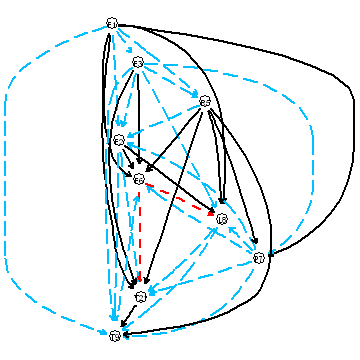

In [221]:
score1a = learn_structure(reactor, "reactor", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


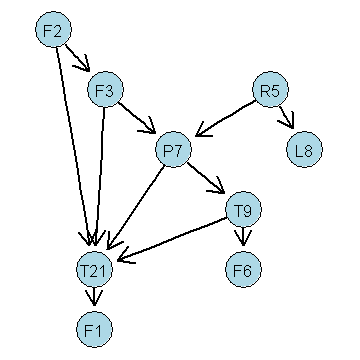

score = AIC, dataset = 1d


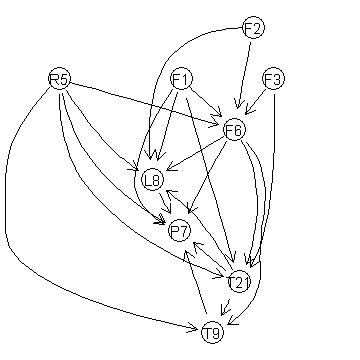

[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.272727272727273"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.181818181818182"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


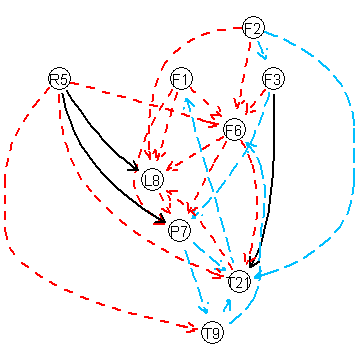

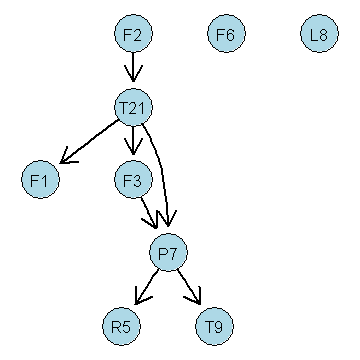

score = BIC, dataset = 1d


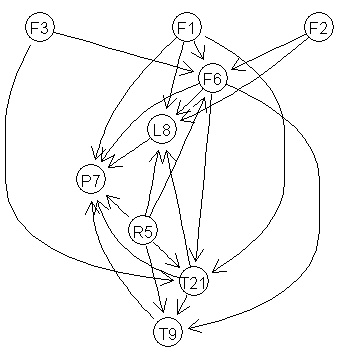

[1] "True Positive          =  1"
[1] "False Positive         =  21"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.142857142857143"
[1] "Precision              =  0.0454545454545455"
[1] "F1 score               =  0.0689655172413793"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


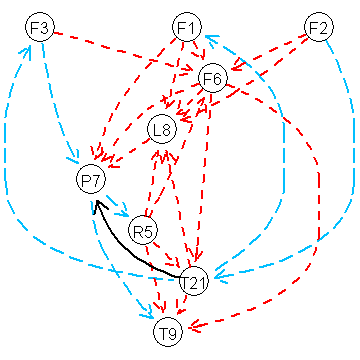

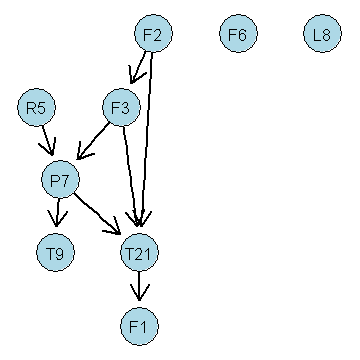

score = BGE, dataset = 1d


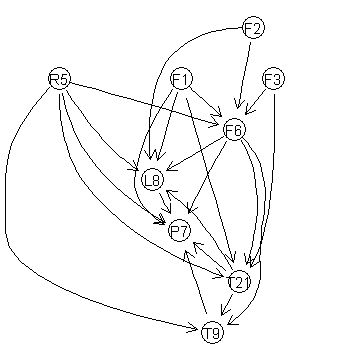

[1] "True Positive          =  2"
[1] "False Positive         =  20"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.25"
[1] "Precision              =  0.0909090909090909"
[1] "F1 score               =  0.133333333333333"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


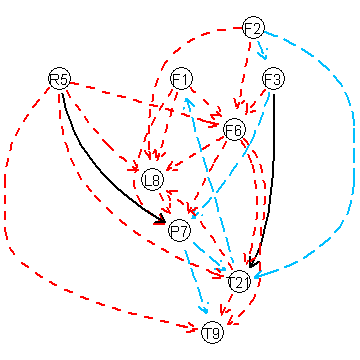

ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


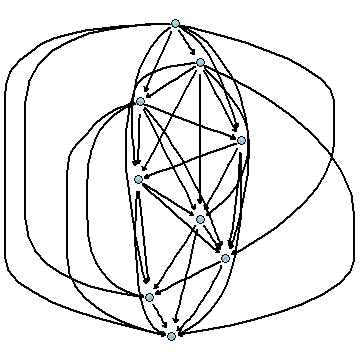

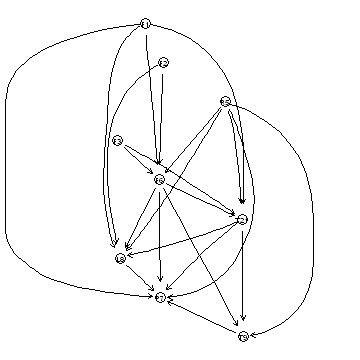

In [216]:
score1d = learn_structure(reactor, "reactor", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


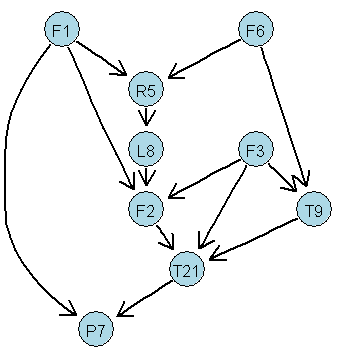

score = AIC, dataset = 3a


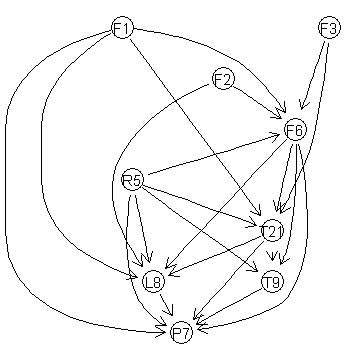

[1] "True Positive          =  5"
[1] "False Positive         =  17"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.384615384615385"
[1] "Precision              =  0.227272727272727"
[1] "F1 score               =  0.285714285714286"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


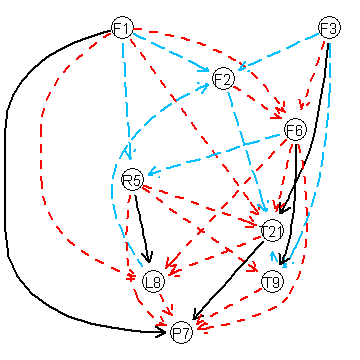

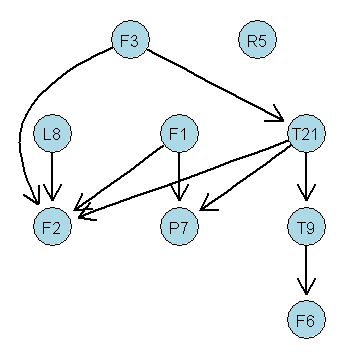

score = BIC, dataset = 3a


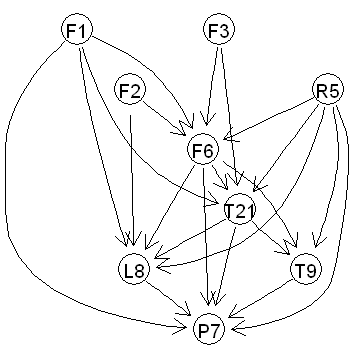

[1] "True Positive          =  4"
[1] "False Positive         =  18"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.181818181818182"
[1] "F1 score               =  0.258064516129032"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


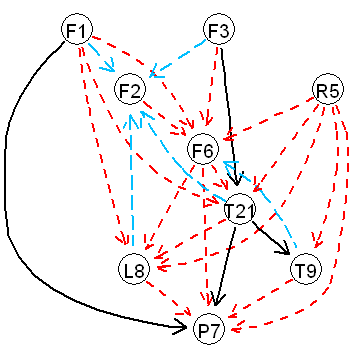

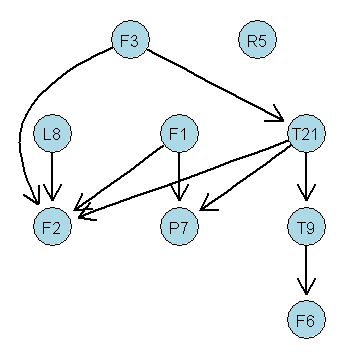

score = BGE, dataset = 3a


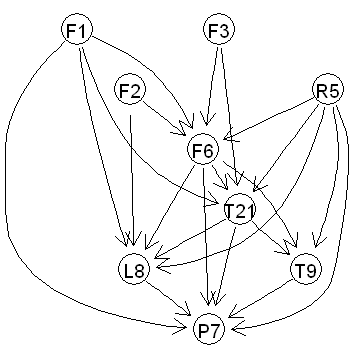

[1] "True Positive          =  4"
[1] "False Positive         =  18"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.181818181818182"
[1] "F1 score               =  0.258064516129032"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


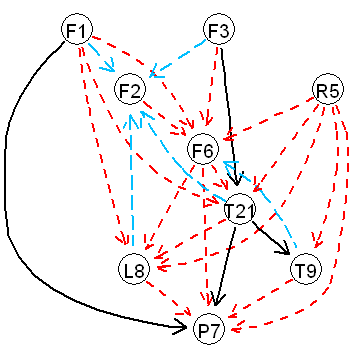

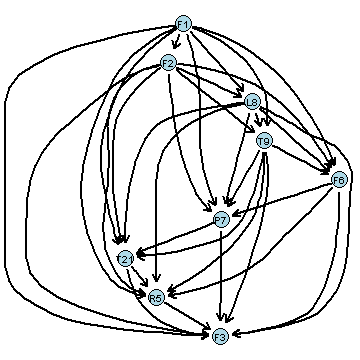

score = LOGLIKE, dataset = 3a


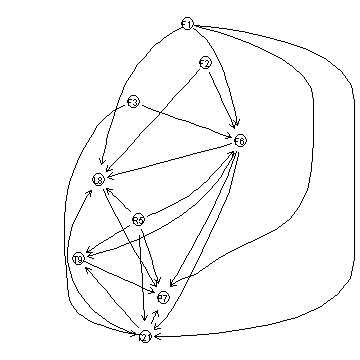

[1] "True Positive          =  9"
[1] "False Positive         =  13"
[1] "False Negative         =  25"
[1] "Recall (sensitivity)   =  0.264705882352941"
[1] "Precision              =  0.409090909090909"
[1] "F1 score               =  0.321428571428571"


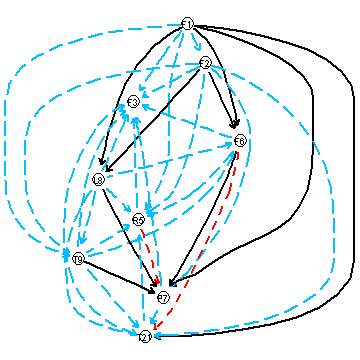

In [217]:
score3a = learn_structure(reactor, "reactor", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


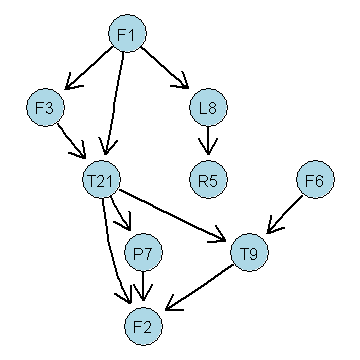

score = AIC, dataset = 3d


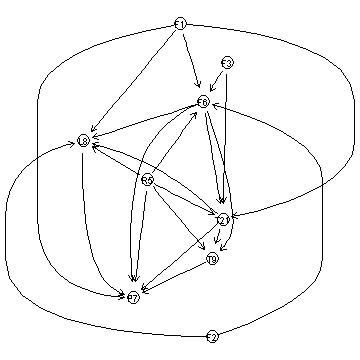

[1] "True Positive          =  6"
[1] "False Positive         =  16"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.545454545454545"
[1] "Precision              =  0.272727272727273"
[1] "F1 score               =  0.363636363636364"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


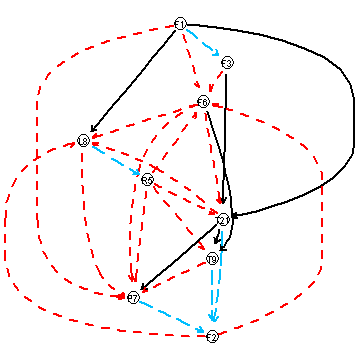

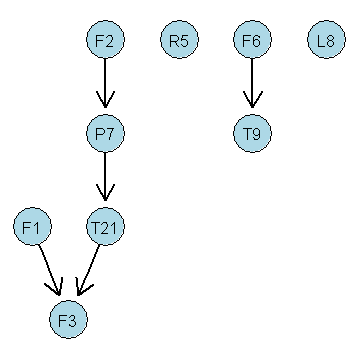

score = BIC, dataset = 3d


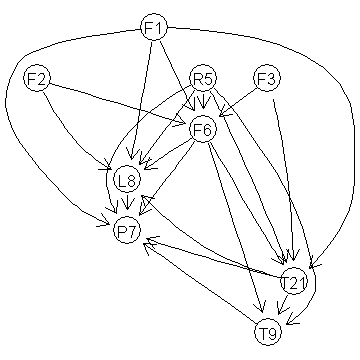

[1] "True Positive          =  1"
[1] "False Positive         =  21"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.0454545454545455"
[1] "F1 score               =  0.0740740740740741"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


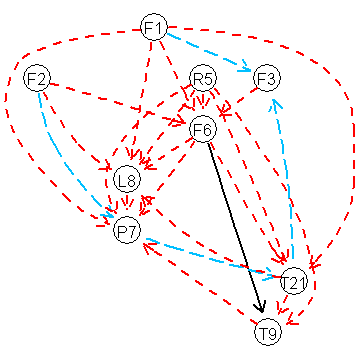

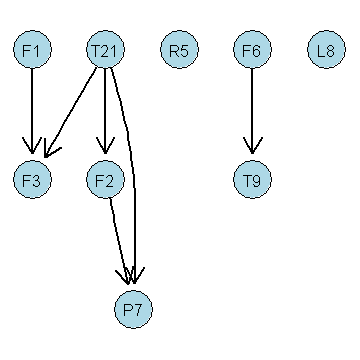

score = BGE, dataset = 3d


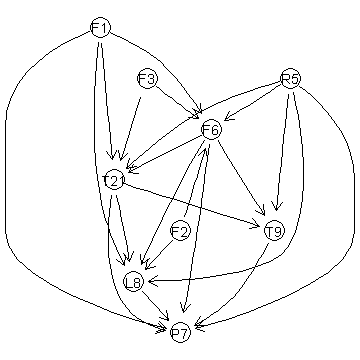

[1] "True Positive          =  2"
[1] "False Positive         =  20"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.0909090909090909"
[1] "F1 score               =  0.142857142857143"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


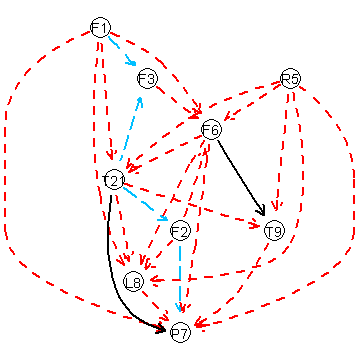

ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


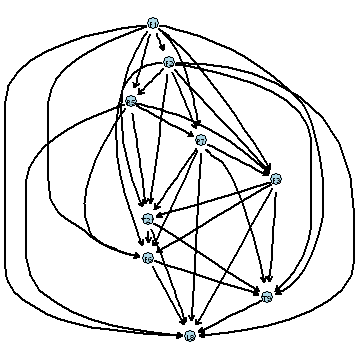

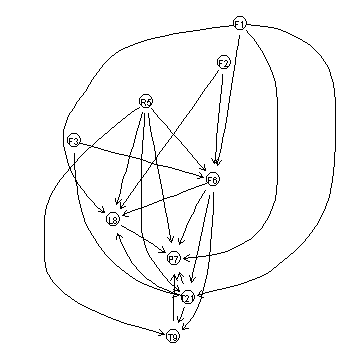

In [218]:
score3d = learn_structure(reactor, "reactor", "3d")

### [Reactor] Comparison of F1 scores across various score-based methods and datasets

In [219]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge,loglike
score1a,0.4,0.2666667,0.2,0.5
score1d,0,0,0,0.5714286
score3a,0.2857143,0.2580645,0.2580645,0.3214286
score3d,0.3529412,0,0.07142857,0.5172414


<hr>

<span style="color:red"><font size="6"><b>7c. CONDENSER...</b></font></span>

### [Condenser] 3 configurations: 1 true and 2 randoms

In [79]:
condenser <- model2network("[T9][T22|T9]")
condenser_rnd1 <- random.graph(nodes = c( "T22", "T9"))
condenser_rnd2 <- random.graph(nodes = c( "T22", "T9"))

### [Condenser] Plotting graphs of all three configurations

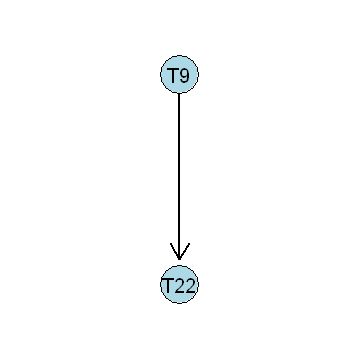

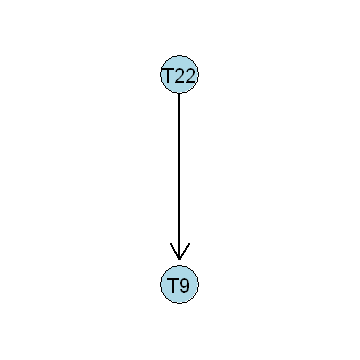

In [80]:
plot_graph(condenser)
plot_graph(condenser_rnd1)
plot_graph(condenser_rnd2)

### [Condenser] Comparing true graph with random graph

[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


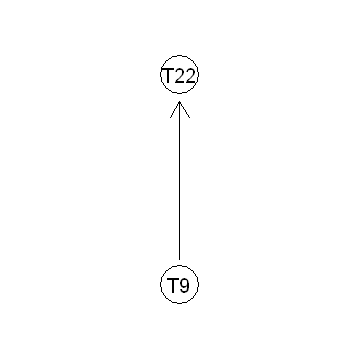

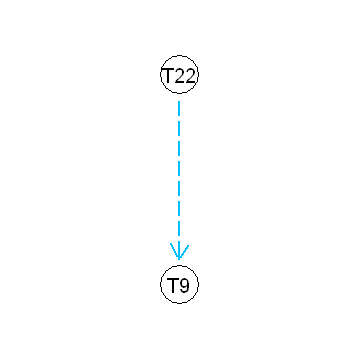

In [101]:
garbage =compare_models(condenser_rnd1, condenser)
compare_graph(condenser, condenser_rnd1)

### [Condenser] Fitting each of the three into linear gaussian model.

In [102]:
gaussian_condenser <- gaussian(condenser, read_data("condenser", "1a"))
gaussian_condenser_rnd1 <- gaussian(condenser_rnd1, read_data("condenser", "1a"))
gaussian_condenser_rnd2 <- gaussian(condenser_rnd2, read_data("condenser", "1a"))

[1] "[T9][T22|T9]"
[1] "[T22][T9|T22]"
[1] "[T22][T9|T22]"


### [Condenser] Comparing scores across 3 configurations and 4 datasets.

In [103]:
compare_scores(condenser, condenser_rnd1, condenser_rnd2, "condenser")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-2832.883,-2835.883,-2843.246,-2845.225,-2829.75,-2832.75,-2840.113,-2842.103,-2839.693,-2842.693,-2850.056,-2852.009,-2839.693,-2842.693,-2850.056,-2852.009
-2832.883,-2835.883,-2843.246,-2845.225,-2829.75,-2832.75,-2840.113,-2842.103,-2839.693,-2842.693,-2850.056,-2852.009,-2839.693,-2842.693,-2850.056,-2852.009
-2832.883,-2835.883,-2843.246,-2845.225,-2829.75,-2832.75,-2840.113,-2842.103,-2839.693,-2842.693,-2850.056,-2852.009,-2839.693,-2842.693,-2850.056,-2852.009


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Condenser] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


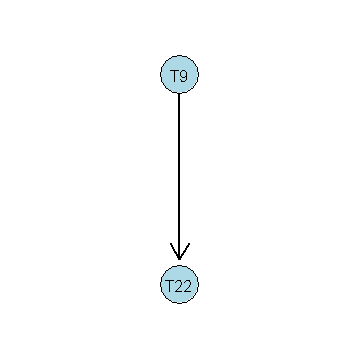

score = AIC, dataset = 1a


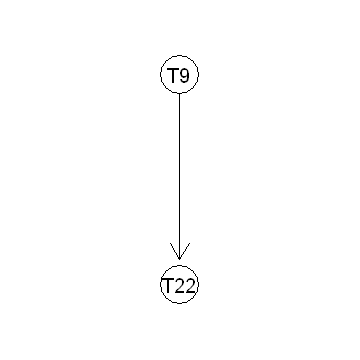

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


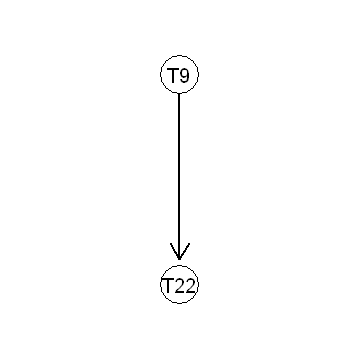

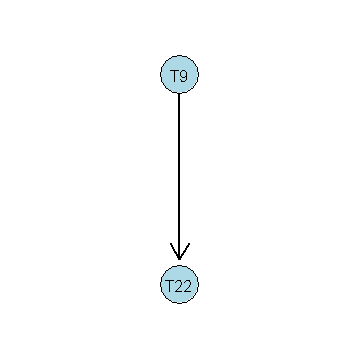

score = BIC, dataset = 1a


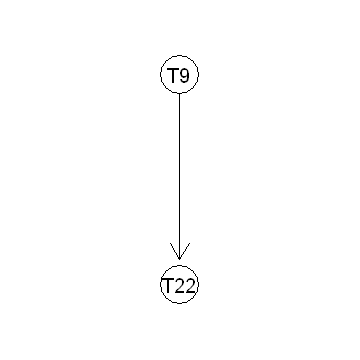

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


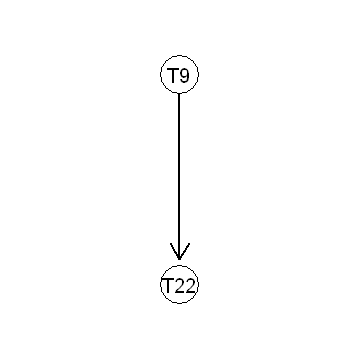

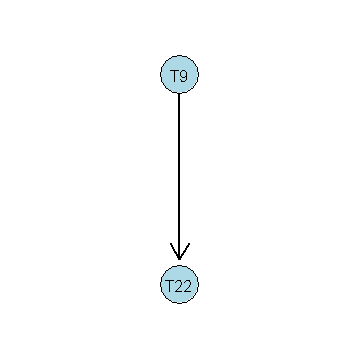

score = BGE, dataset = 1a


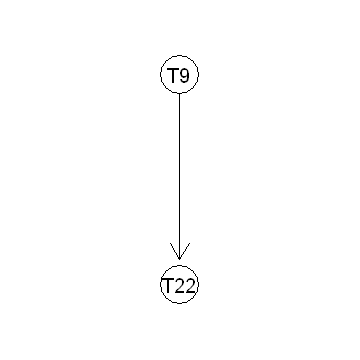

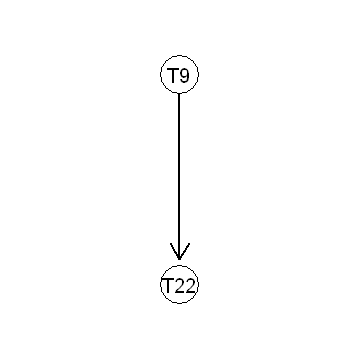

In [104]:
score1a = learn_structure(condenser, "condenser", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


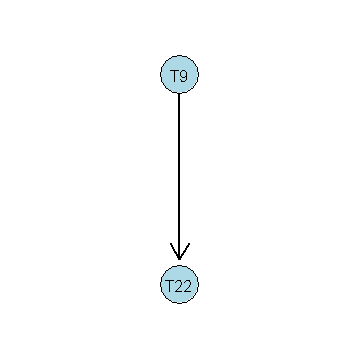

score = AIC, dataset = 1d


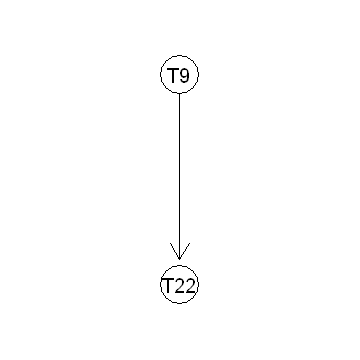

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


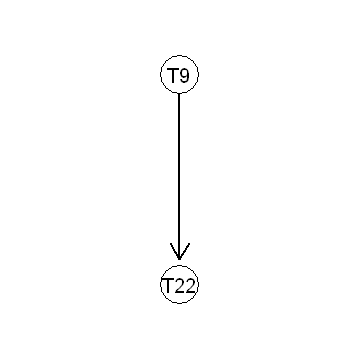

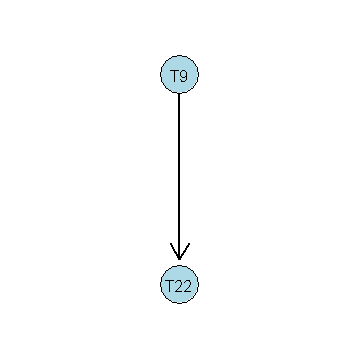

score = BIC, dataset = 1d


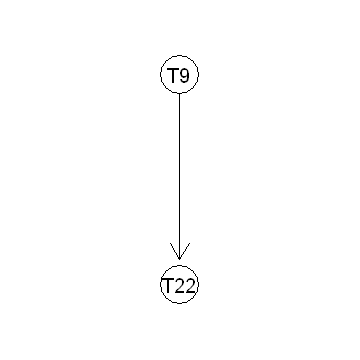

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


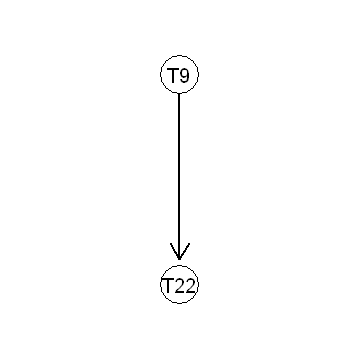

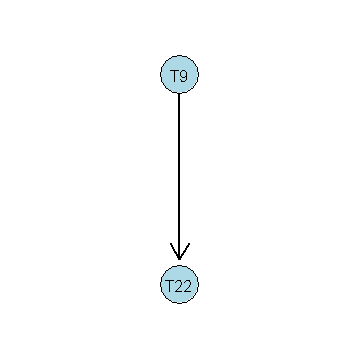

score = BGE, dataset = 1d


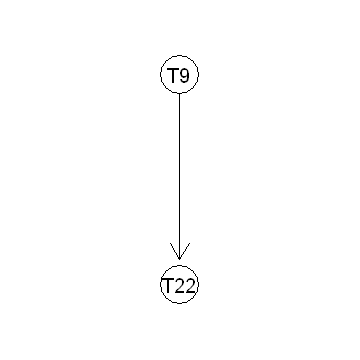

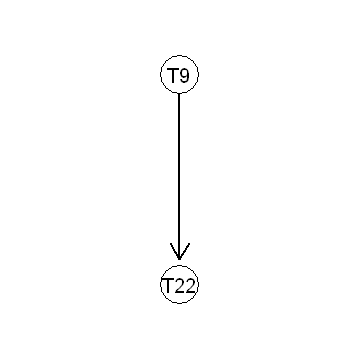

In [105]:
score1d = learn_structure(condenser, "condenser", "1d")

Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


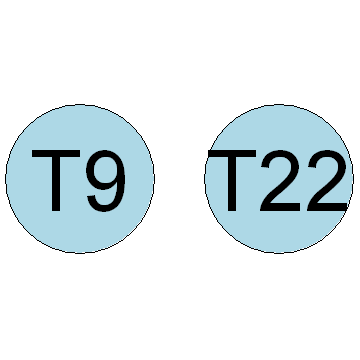

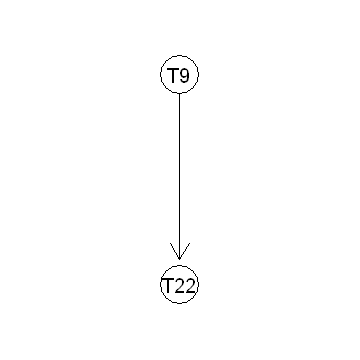

In [106]:
score3a = learn_structure(condenser, "condenser", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


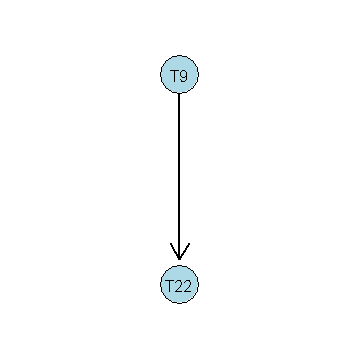

score = AIC, dataset = 3d
Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."

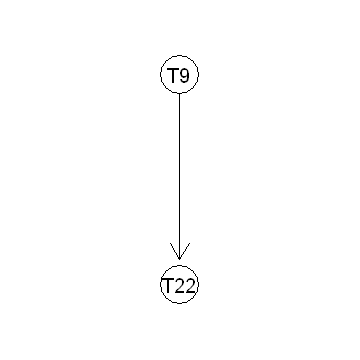

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


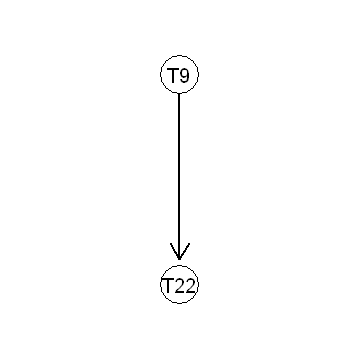

ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


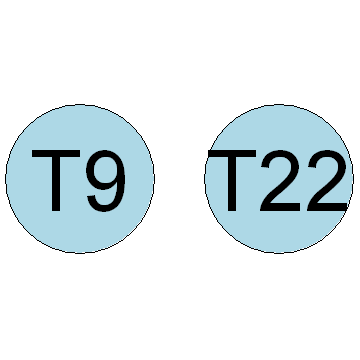

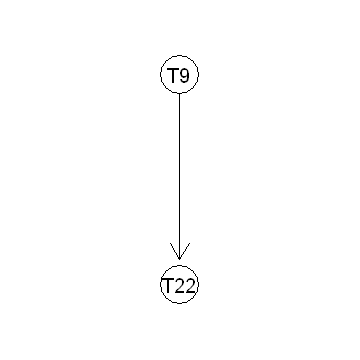

In [107]:
score3d = learn_structure(condenser, "condenser", "3d")

### [Condenser] Comparison of F1 scores across various score-based methods and datasets

In [108]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge
score1a,1,1,1
score1d,1,1,1
score3a,0.2162162,0.2580645,0.2580645
score3d,0.1212121,0.07407407,0.07142857


<hr>

<span style="color:red"><font size="6"><b>7d. SEPARATOR...</b></font></span>

### [Separator] 3 configurations: 1 true and 2 randoms

In [110]:
separator <- model2network("[T9][T22|T9][L8][P7|L8][T11|T22:T9:L8][L12|P7:L8:P13][P13|P7:L8:T22][F14|P7:L8:L12:T22:T11]")
separator_rnd1 <- random.graph(nodes = c("P7", "L8", "T9", "T22", "T11", "L12", "P13", "F14"))
separator_rnd2 <- random.graph(nodes = c("P7", "L8", "T9", "T22", "T11", "L12", "P13", "F14"))

### [Separator] Plotting graphs of all three configurations

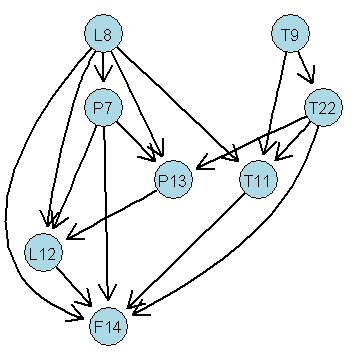

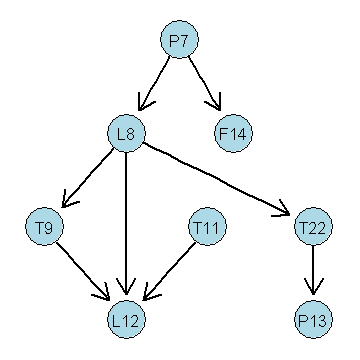

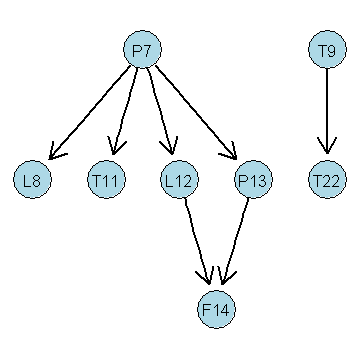

In [111]:
plot_graph(separator)
plot_graph(separator_rnd1)
plot_graph(separator_rnd2)

### [Separator] Comparing true graph with random graph

[1] "True Positive          =  3"
[1] "False Positive         =  5"
[1] "False Negative         =  13"
[1] "Recall (sensitivity)   =  0.1875"
[1] "Precision              =  0.375"
[1] "F1 score               =  0.25"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


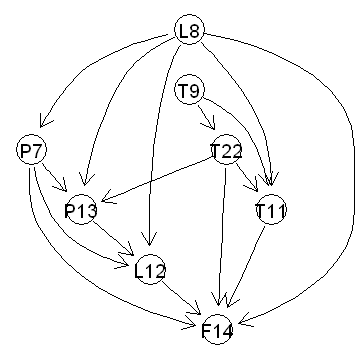

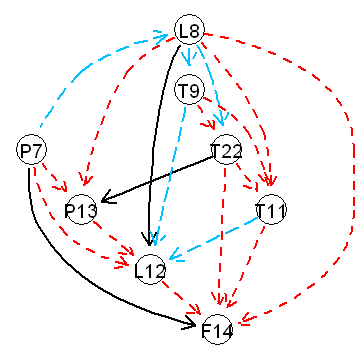

In [112]:
garbage =compare_models(separator_rnd1, separator)
compare_graph(separator, separator_rnd1)

### [Separator] Fitting each of the three into linear gaussian model.

In [113]:
gaussian_separator <- gaussian(separator, read_data("separator", "1a"))
gaussian_separator_rnd1 <- gaussian(separator_rnd1, read_data("separator", "1a"))
gaussian_separator_rnd2 <- gaussian(separator_rnd2, read_data("separator", "1a"))

[1] "[L8][T9][P7|L8][T22|T9][P13|L8:P7:T22][T11|L8:T22:T9][L12|L8:P13:P7][F14|L12:L8:P7:T11:T22]"
[1] "[P7][T11][L8|P7][F14|P7][T9|L8][T22|L8][L12|L8:T9:T11][P13|T22]"
[1] "[P7][T9][L8|P7][T22|T9][T11|P7][L12|P7][P13|P7][F14|L12:P13]"


### [Separator] Comparing scores across 3 configurations and 4 datasets.

In [114]:
compare_scores(separator, separator_rnd1, separator_rnd2, "separator")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-10285.97,-10309.97,-10368.88,-10390.86,-10305.31,-10329.31,-10388.21,-10408.68,-10195.36,-10219.36,-10278.27,-10322.17,-10195.36,-10219.36,-10278.27,-10322.17
-11332.16,-11348.16,-11387.43,-11392.06,-11317.29,-11333.29,-11372.56,-11377.25,-11335.24,-11351.24,-11390.51,-11395.13,-11335.24,-11351.24,-11390.51,-11395.13
-10461.44,-10476.44,-10513.25,-10542.12,-10460.68,-10475.68,-10512.49,-10540.36,-10178.34,-10193.34,-10230.15,-10282.37,-10178.34,-10193.34,-10230.15,-10282.37


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Separator] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


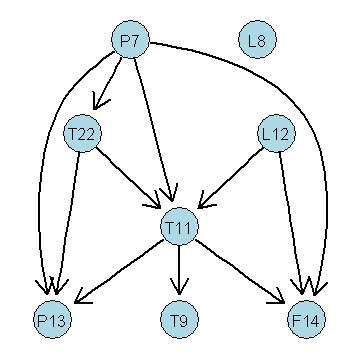

score = AIC, dataset = 1a


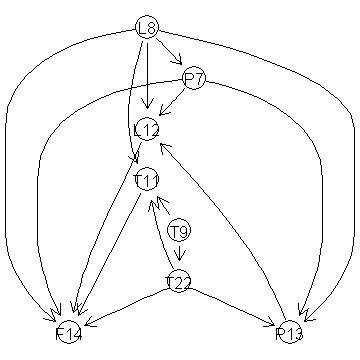

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


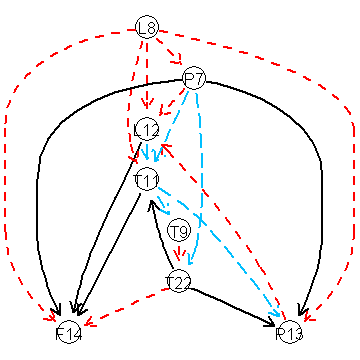

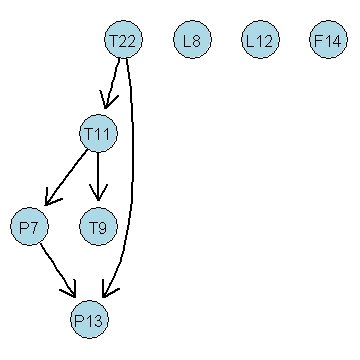

score = BIC, dataset = 1a


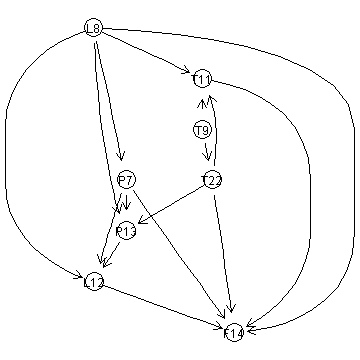

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


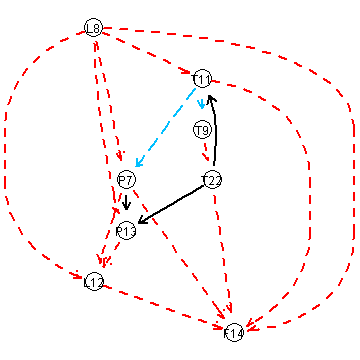

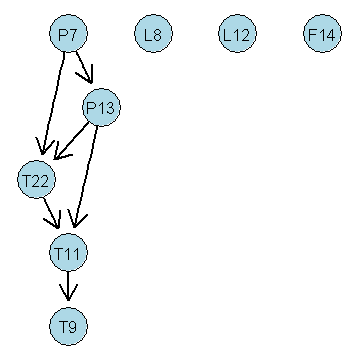

score = BGE, dataset = 1a


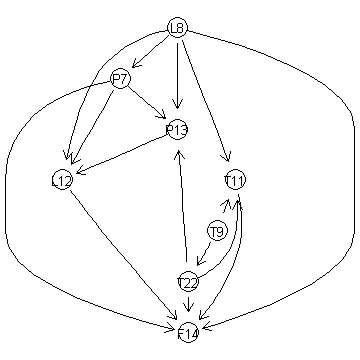

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


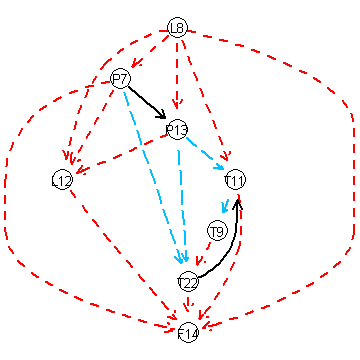

ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


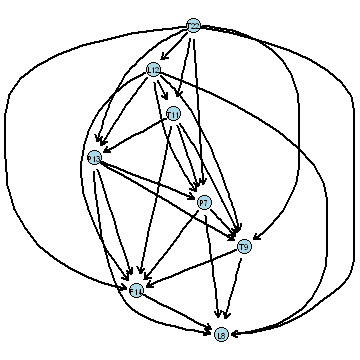

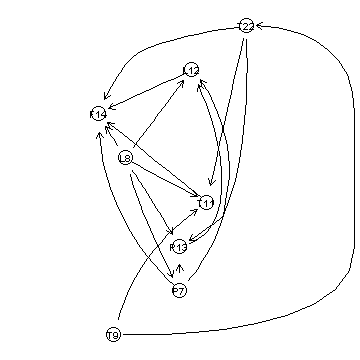

In [186]:
score1a = learn_structure(separator, "separator", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


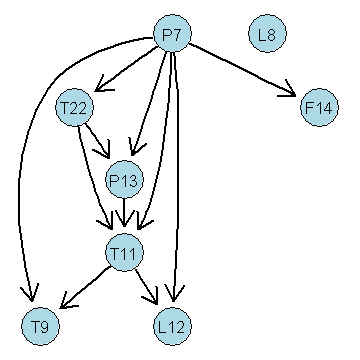

score = AIC, dataset = 1d


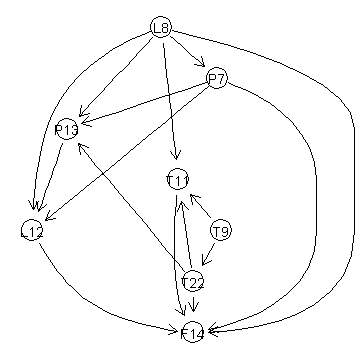

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


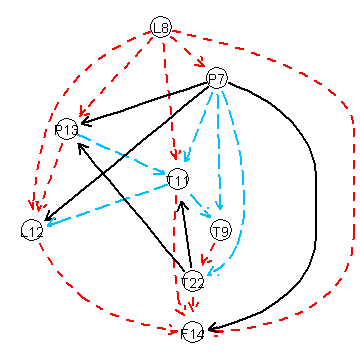

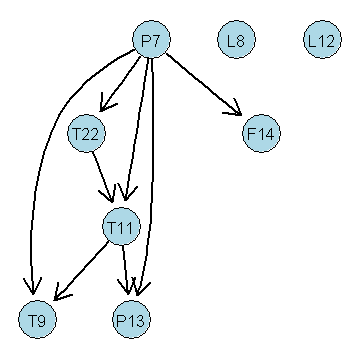

score = BIC, dataset = 1d


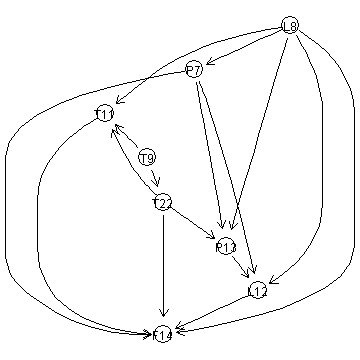

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


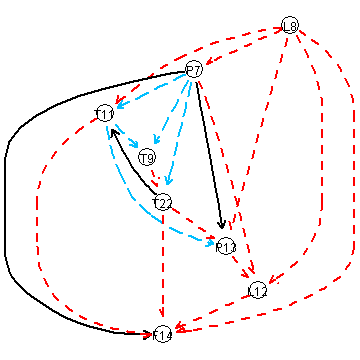

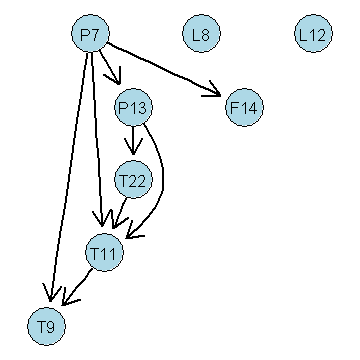

score = BGE, dataset = 1d


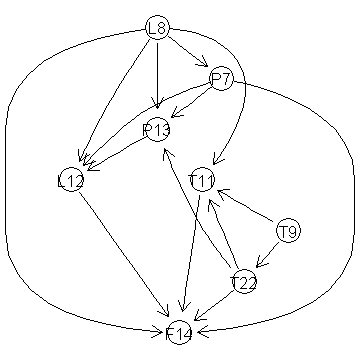

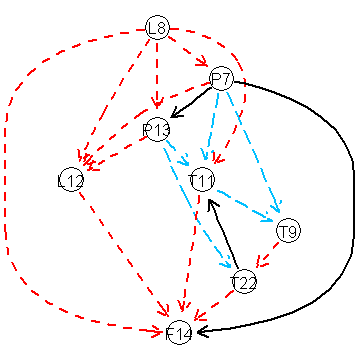

In [116]:
score1d = learn_structure(separator, "separator", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


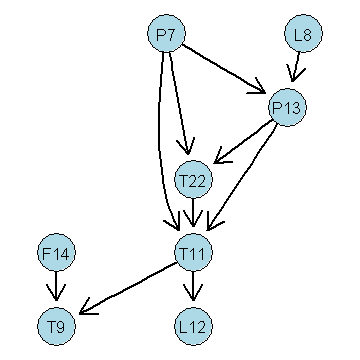

score = AIC, dataset = 3a


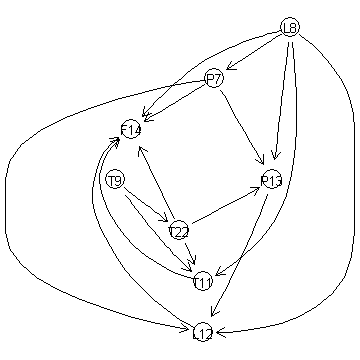

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


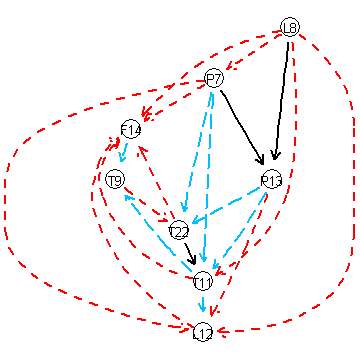

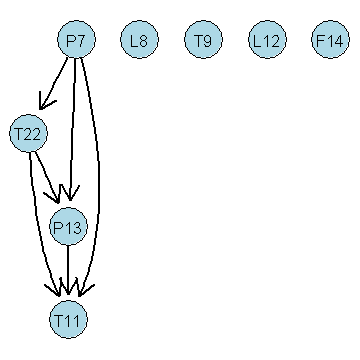

score = BIC, dataset = 3a


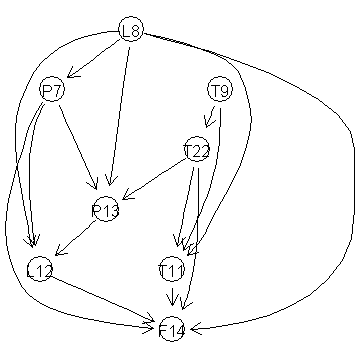

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


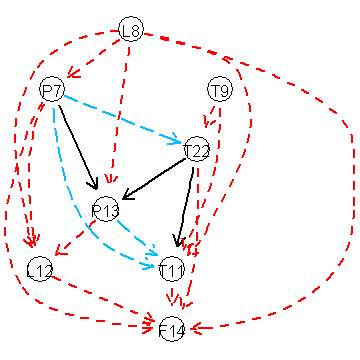

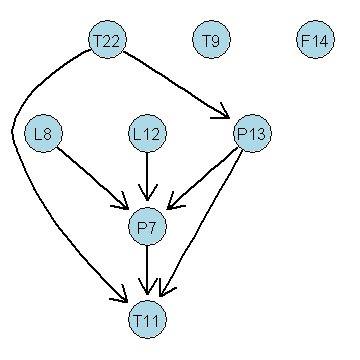

score = BGE, dataset = 3a


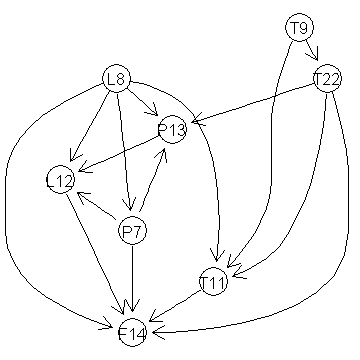

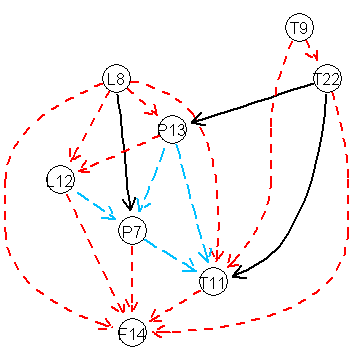

In [117]:
score3a = learn_structure(separator, "separator", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


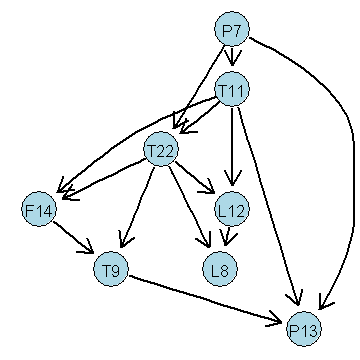

score = AIC, dataset = 3d


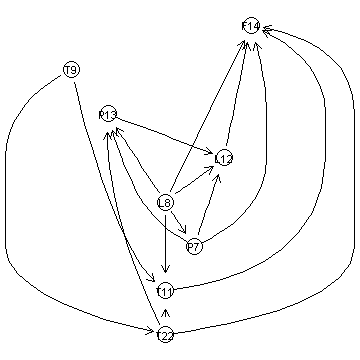

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


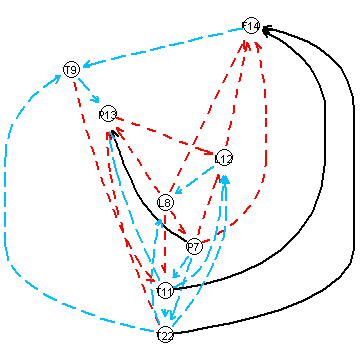

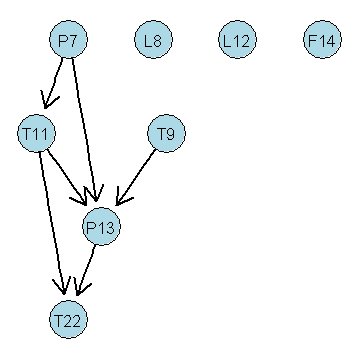

score = BIC, dataset = 3d


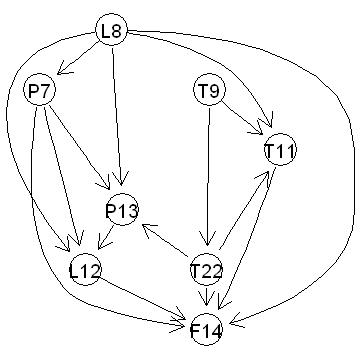

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


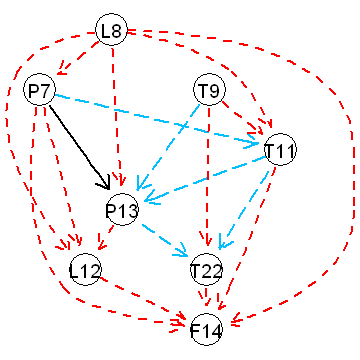

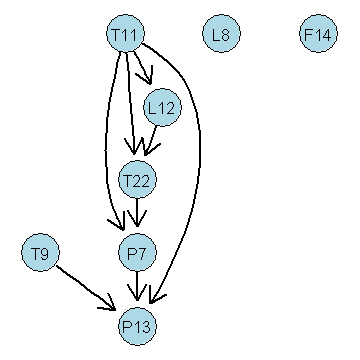

score = BGE, dataset = 3d


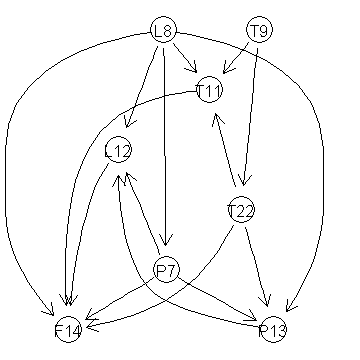

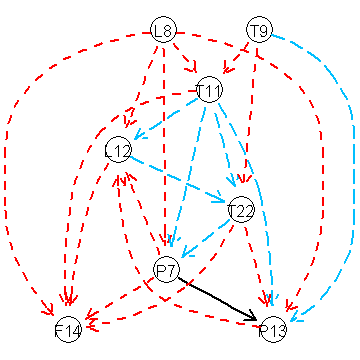

In [118]:
score3d = learn_structure(separator, "separator", "3d")

### [Separator] Comparison of F1 scores across various score-based methods and datasets

In [119]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge
score1a,0.3703704,0,0.09090909
score1d,0.3703704,0.25,0.25
score3a,0.2307692,0.2727273,0.2608696
score3d,0.2,0.09090909,0.08333333


<hr>

<span style="color:red"><font size="6"><b>7e. STRIPPER...</b></font></span>

### [Stripper] 3 configurations: 1 true and 2 randoms

In [120]:
stripper <- model2network("[F4][T11][F14|T11:L12][P13][L12|P13][L15|F14:F4:T11:L12][P16|T11:L12:P13:F14:F4:L15:F17:T18][F17|L12:P13:F14:L15:F19][T18|L12:P13:F14:L15:F4][F19|F4:T18]")
stripper_rnd1 <- random.graph(nodes = c("T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19"))
stripper_rnd2 <- random.graph(nodes = c("T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19"))

### [Stripper] Plotting graphs of all three configurations

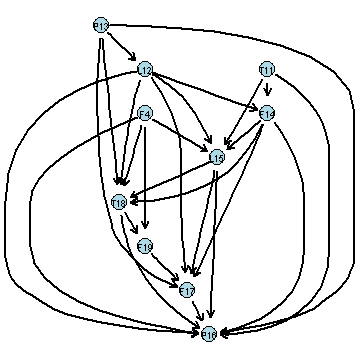

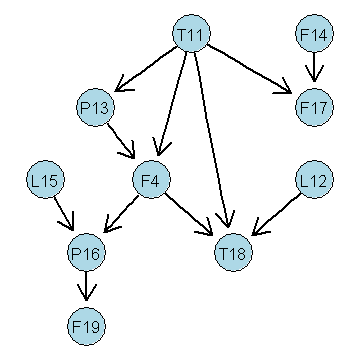

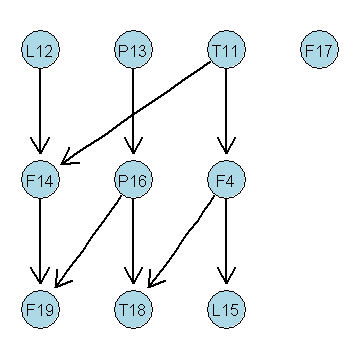

In [121]:
plot_graph(stripper)
plot_graph(stripper_rnd1)
plot_graph(stripper_rnd2)

### [Stripper] Comparing true graph with random graph

[1] "True Positive          =  5"
[1] "False Positive         =  6"
[1] "False Negative         =  22"
[1] "Recall (sensitivity)   =  0.185185185185185"
[1] "Precision              =  0.454545454545455"
[1] "F1 score               =  0.263157894736842"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


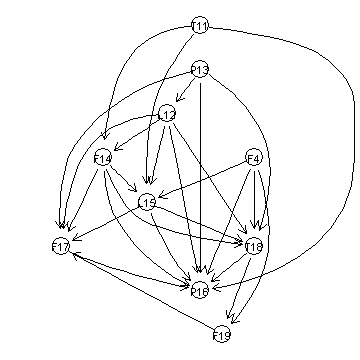

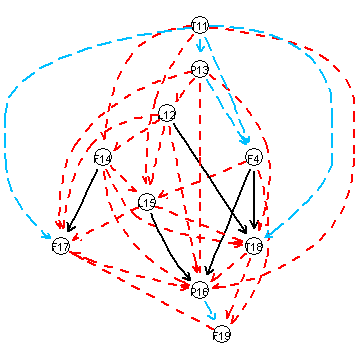

In [123]:
garbage =compare_models(stripper_rnd1, stripper)
compare_graph(stripper, stripper_rnd1)

### [Stripper] Fitting each of the three into linear gaussian model.

In [124]:
gaussian_stripper <- gaussian(stripper, read_data("stripper", "1a"))
gaussian_stripper_rnd1 <- gaussian(stripper_rnd1, read_data("stripper", "1a"))
gaussian_stripper_rnd2 <- gaussian(stripper_rnd2, read_data("stripper", "1a"))

[1] "[F4][P13][T11][L12|P13][F14|L12:T11][L15|F14:F4:L12:T11][T18|F14:F4:L12:L15:P13][F19|F4:T18][F17|F14:F19:L12:L15:P13][P16|F14:F17:F4:L12:L15:P13:T11:T18]"
[1] "[T11][L12][F14][L15][P13|T11][F17|T11:F14][F4|T11:P13][P16|F4:L15][T18|T11:L12:F4][F19|P16]"
[1] "[T11][L12][P13][F17][F14|T11:L12][F4|T11][P16|P13][L15|F4][T18|F4:P16][F19|F14:P16]"


### [Stripper] Comparing scores across 3 configurations and 4 datasets.

In [125]:
compare_scores(stripper, stripper_rnd1, stripper_rnd2, "stripper")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-13280.56,-13317.56,-13408.37,-13420.08,-13247.79,-13284.79,-13375.60,-13389.56,-13495.75,-13532.75,-13623.56,-13622.65,-13495.75,-13532.75,-13623.56,-13622.65
-13876.19,-13897.19,-13948.73,-13955.55,-13860.60,-13881.60,-13933.14,-13940.17,-13824.28,-13845.28,-13896.83,-13904.49,-13824.28,-13845.28,-13896.83,-13904.49
-13297.44,-13316.44,-13363.07,-13393.19,-13269.50,-13288.50,-13335.13,-13368.00,-13562.19,-13581.19,-13627.82,-13641.55,-13562.19,-13581.19,-13627.82,-13641.55


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Stripper] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


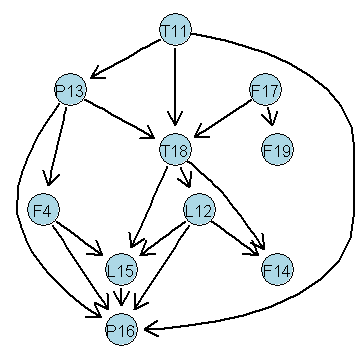

score = AIC, dataset = 1a


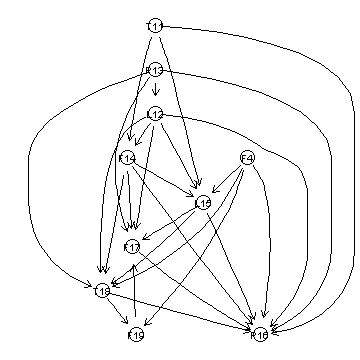

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


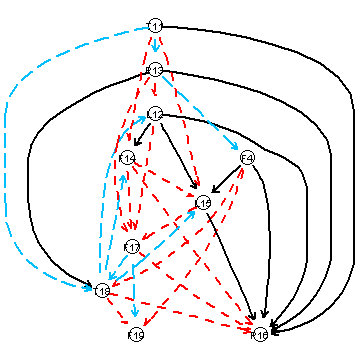

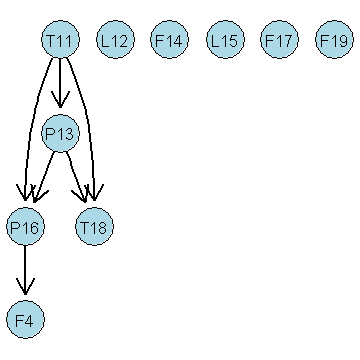

score = BIC, dataset = 1a


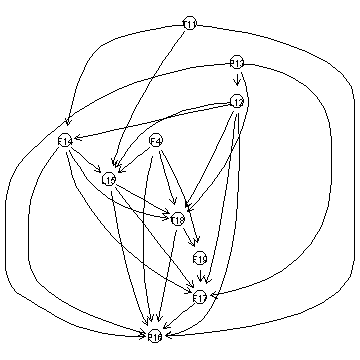

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


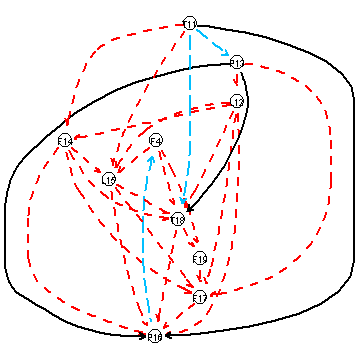

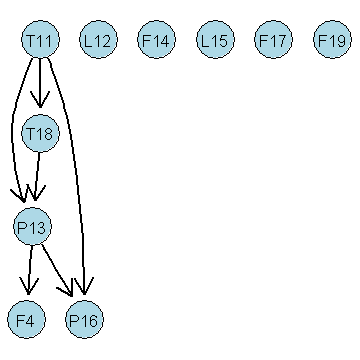

score = BGE, dataset = 1a


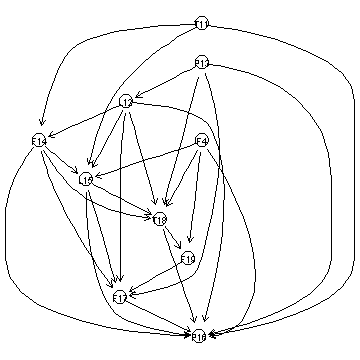

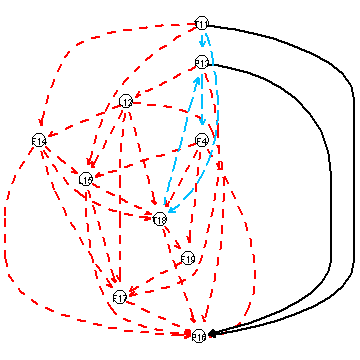

In [126]:
score1a = learn_structure(stripper, "stripper", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


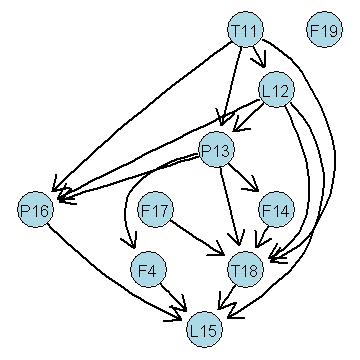

score = AIC, dataset = 1d


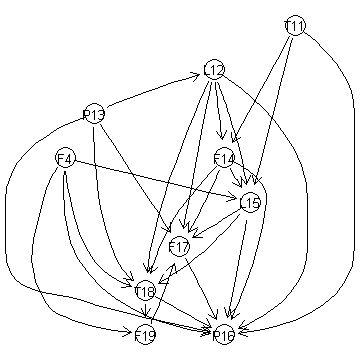

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


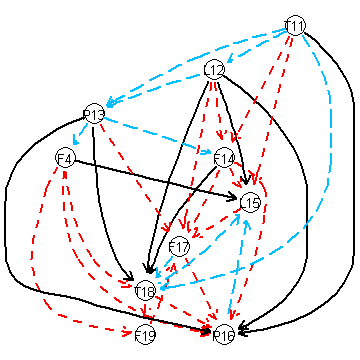

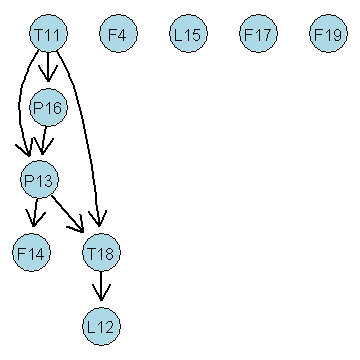

score = BIC, dataset = 1d


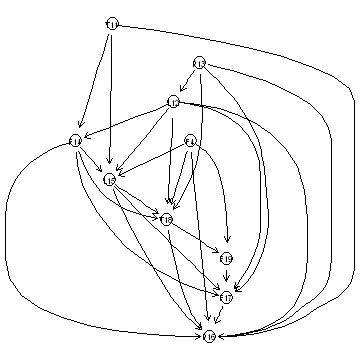

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


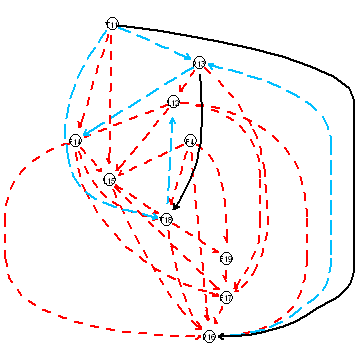

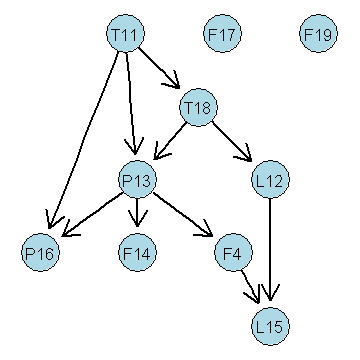

score = BGE, dataset = 1d


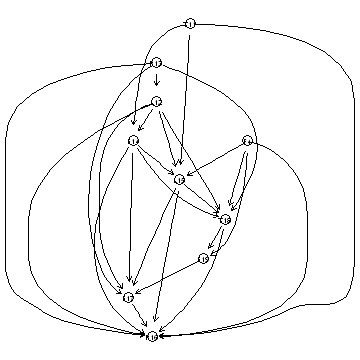

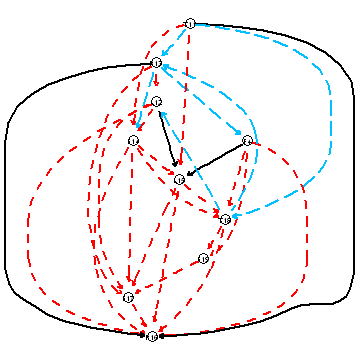

In [127]:
score1d = learn_structure(stripper, "stripper", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


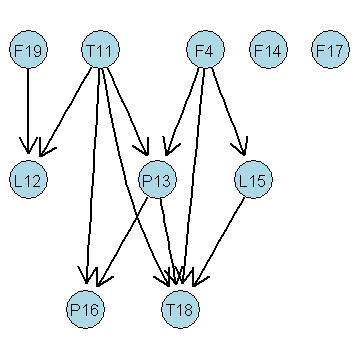

score = AIC, dataset = 3a


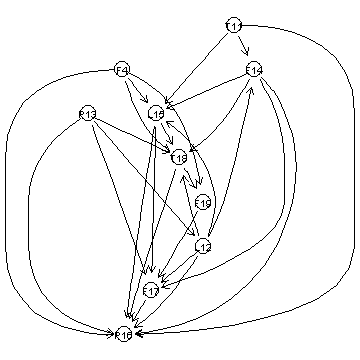

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


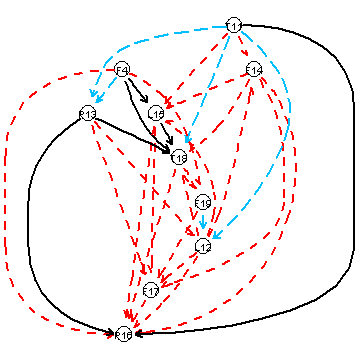

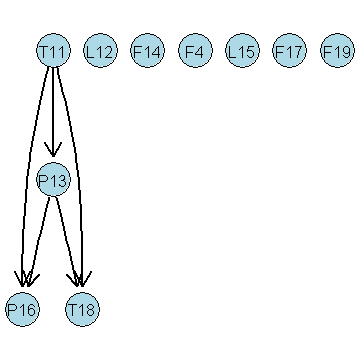

score = BIC, dataset = 3a


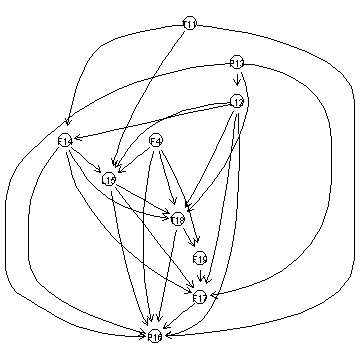

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


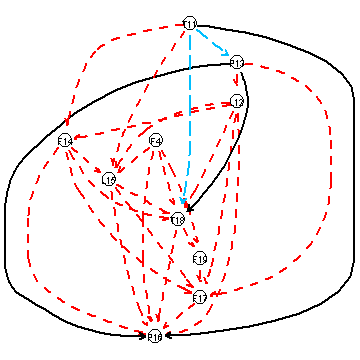

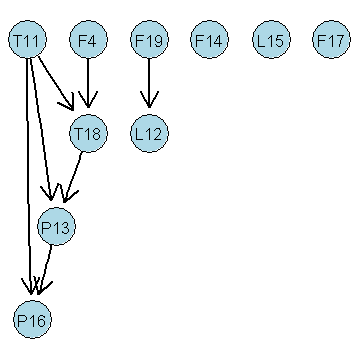

score = BGE, dataset = 3a


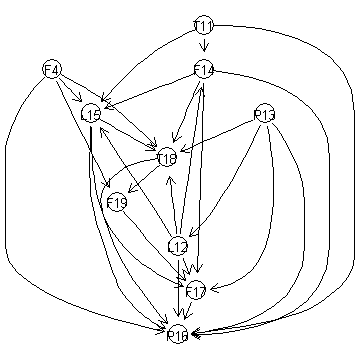

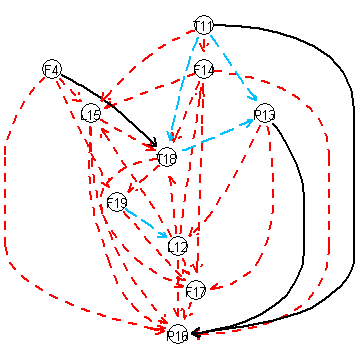

In [128]:
score3a = learn_structure(stripper, "stripper", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


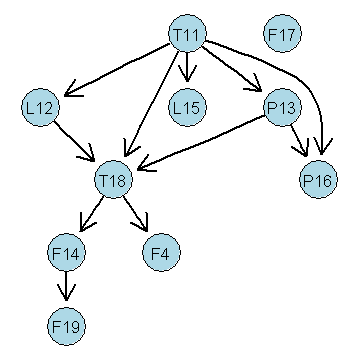

score = AIC, dataset = 3d


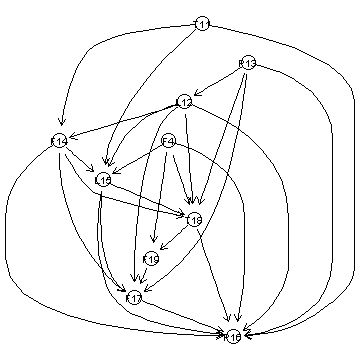

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


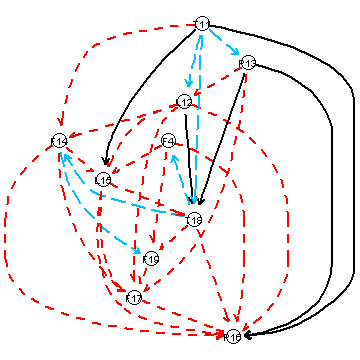

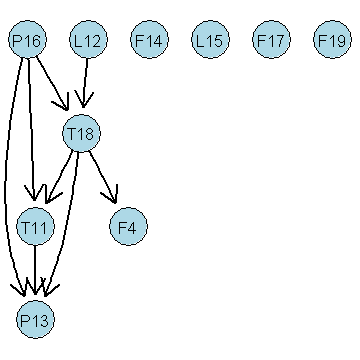

score = BIC, dataset = 3d


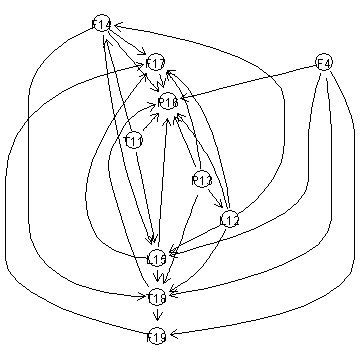

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


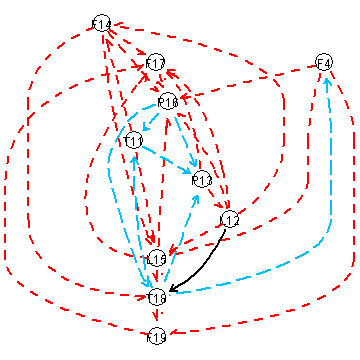

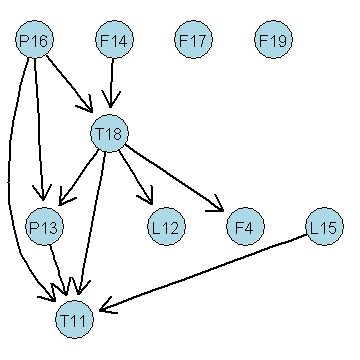

score = BGE, dataset = 3d


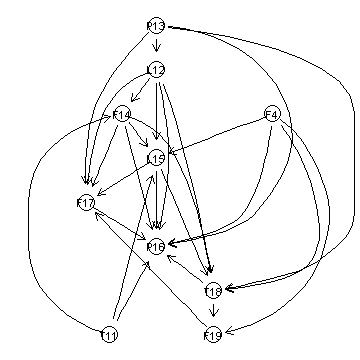

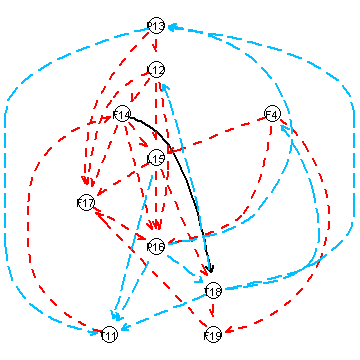

In [129]:
score3d = learn_structure(stripper, "stripper", "3d")

### [Stripper] Comparison of F1 scores across various score-based methods and datasets

In [130]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge
score1a,0.4090909,0.1818182,0.1212121
score1d,0.3636364,0.1176471,0.2162162
score3a,0.3157895,0.1875,0.1764706
score3d,0.2631579,0.05714286,0.05405405


<hr>

<span style="color:red"><font size="6"><b>7f. COMPRESSOR...</b></font></span>

### [Compressor] 3 configurations: 1 true and 2 randoms

In [131]:
compressor <- model2network("[T11][P13][L12|P13][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|J20:F10:L12:P13:T11]")
compressor_rnd1 <- random.graph(nodes = c("F5", "T11", "L12", "P13", "F10", "J20"))
compressor_rnd2 <- random.graph(nodes = c("F5", "T11", "L12", "P13", "F10", "J20"))

### [Compressor] Plotting graphs of all three configurations

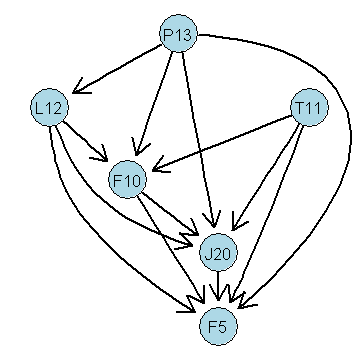

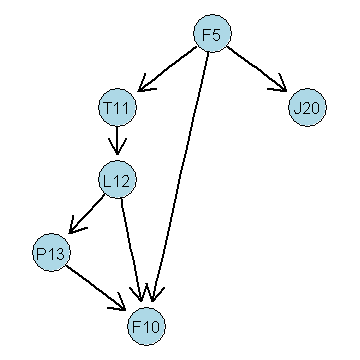

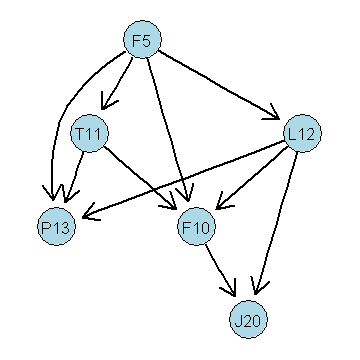

In [132]:
plot_graph(compressor)
plot_graph(compressor_rnd1)
plot_graph(compressor_rnd2)

### [Compressor] Comparing true graph with random graph

[1] "True Positive          =  2"
[1] "False Positive         =  5"
[1] "False Negative         =  11"
[1] "Recall (sensitivity)   =  0.153846153846154"
[1] "Precision              =  0.285714285714286"
[1] "F1 score               =  0.2"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


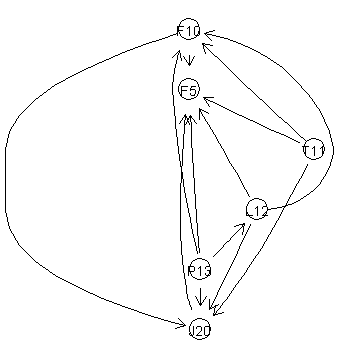

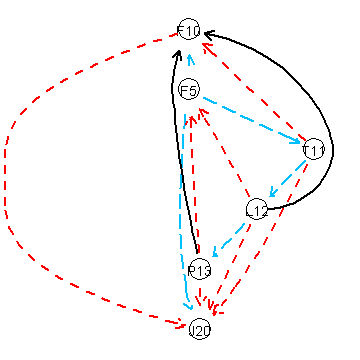

In [134]:
garbage =compare_models(compressor_rnd1, compressor)
compare_graph(compressor, compressor_rnd1)

### [Compressor] Fitting each of the three into linear gaussian model.

In [136]:
gaussian_compressor <- gaussian(compressor, read_data("compressor", "1a"))
gaussian_compressor_rnd1 <- gaussian(compressor_rnd1, read_data("compressor", "1a"))
gaussian_compressor_rnd2 <- gaussian(compressor_rnd2, read_data("compressor", "1a"))

[1] "[P13][T11][L12|P13][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|F10:J20:L12:P13:T11]"
[1] "[F5][T11|F5][J20|F5][L12|T11][P13|L12][F10|F5:L12:P13]"
[1] "[F5][T11|F5][L12|F5][P13|F5:T11:L12][F10|F5:T11:L12][J20|L12:F10]"


### [Compressor] Comparing scores across 3 configurations and 4 datasets.

In [137]:
compare_scores(compressor, compressor_rnd1, compressor_rnd2, "compressor")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-8403.213,-8422.213,-8468.846,-8467.214,-8413.400,-8432.400,-8479.034,-8477.375,-8258.609,-8277.609,-8324.243,-8323.232,-8258.609,-8277.609,-8324.243,-8323.232
-8499.367,-8512.367,-8544.274,-8546.899,-8499.242,-8512.242,-8544.149,-8546.777,-8461.882,-8474.882,-8506.789,-8509.531,-8461.882,-8474.882,-8506.789,-8509.531
-8477.090,-8493.090,-8532.360,-8532.648,-8400.952,-8416.952,-8456.222,-8456.708,-8464.863,-8480.863,-8520.133,-8520.456,-8464.863,-8480.863,-8520.133,-8520.456


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Compressor] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


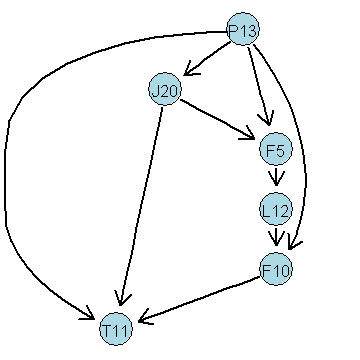

score = AIC, dataset = 1a


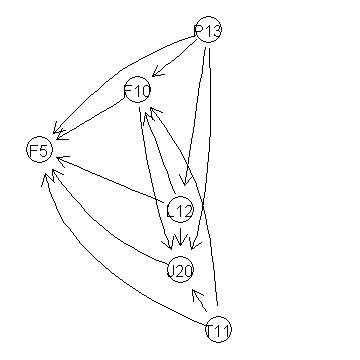

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


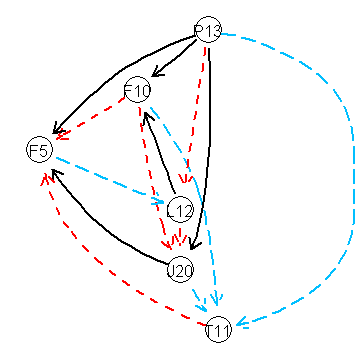

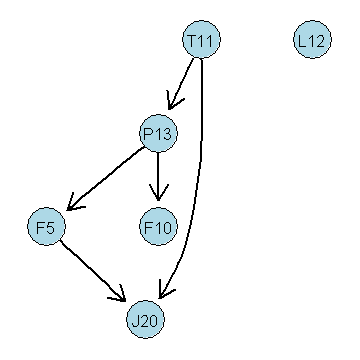

score = BIC, dataset = 1a


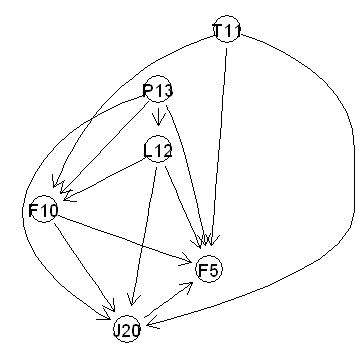

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


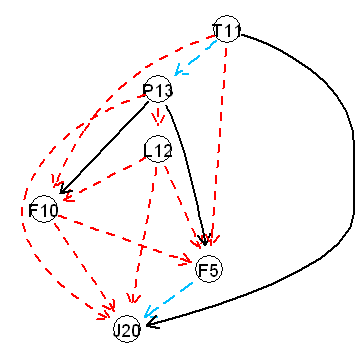

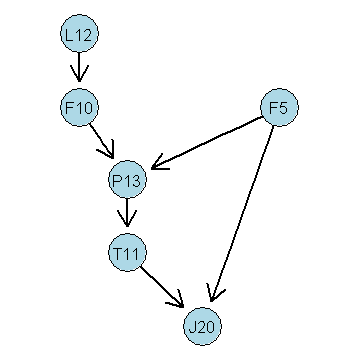

score = BGE, dataset = 1a


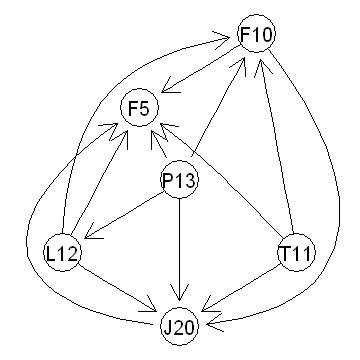

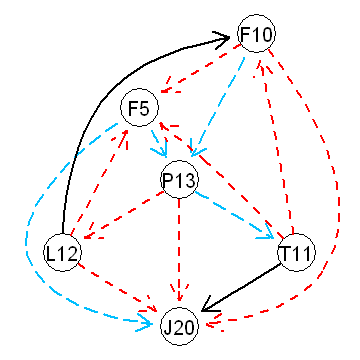

In [138]:
score1a = learn_structure(compressor, "compressor", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


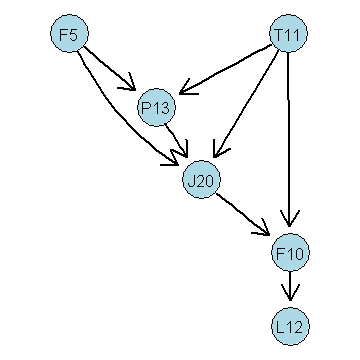

score = AIC, dataset = 1d


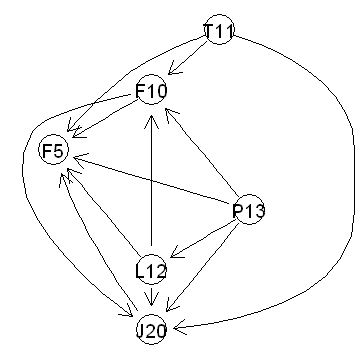

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


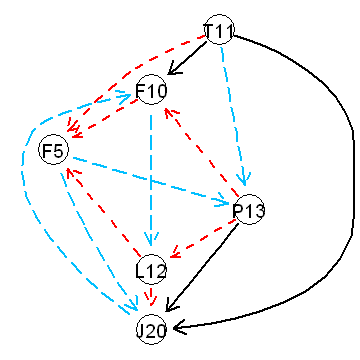

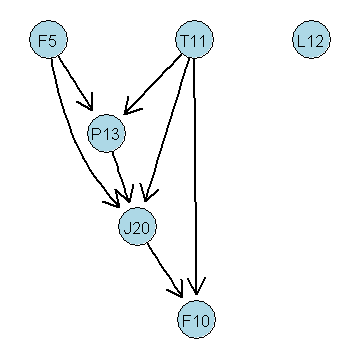

score = BIC, dataset = 1d


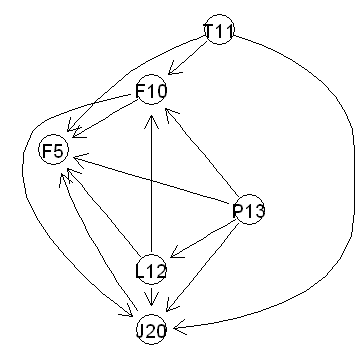

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


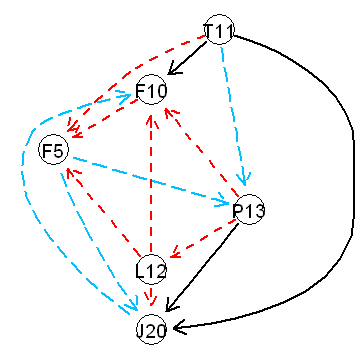

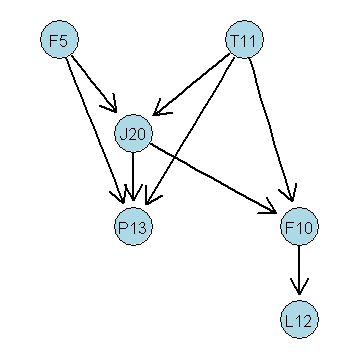

score = BGE, dataset = 1d


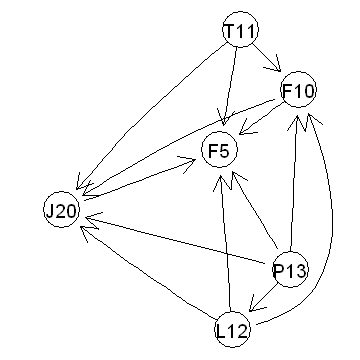

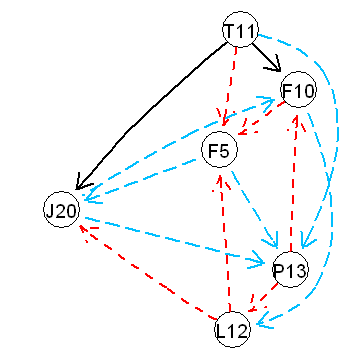

In [139]:
score1d = learn_structure(compressor, "compressor", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


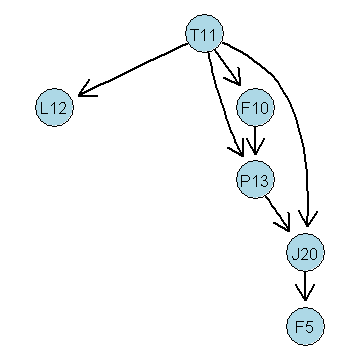

score = AIC, dataset = 3a


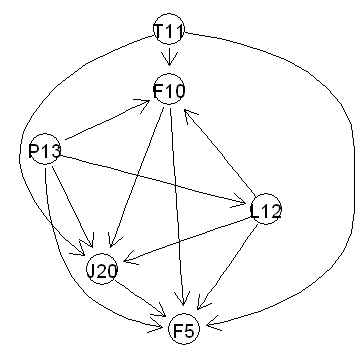

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


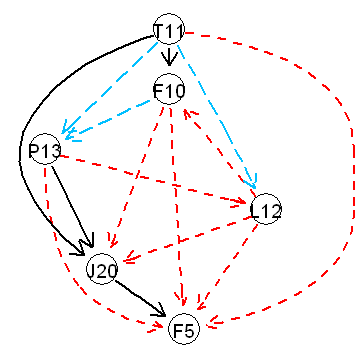

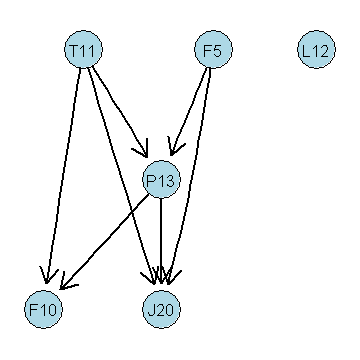

score = BIC, dataset = 3a


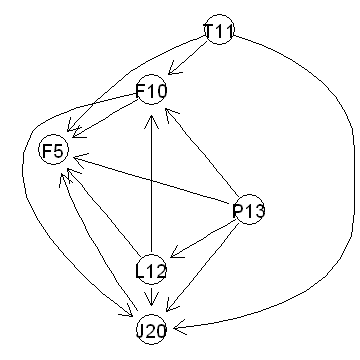

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


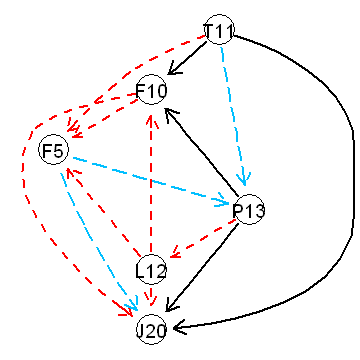

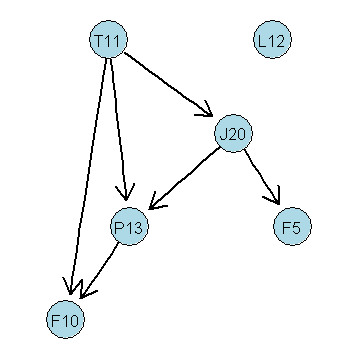

score = BGE, dataset = 3a


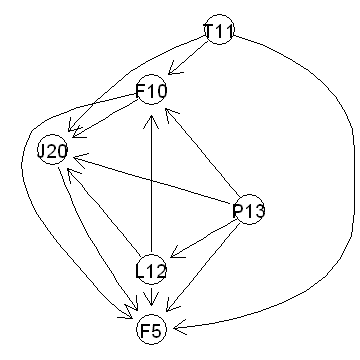

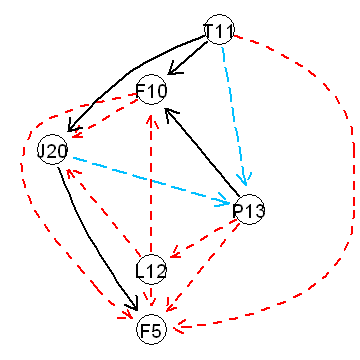

In [140]:
score3a = learn_structure(compressor, "compressor", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


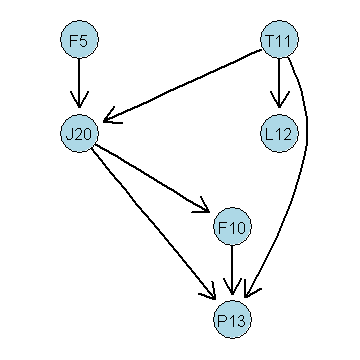

score = AIC, dataset = 3d


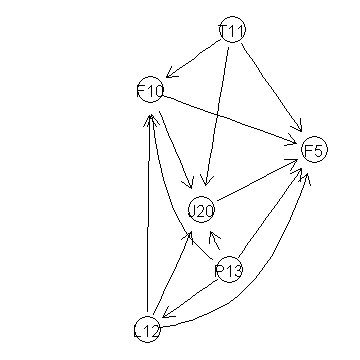

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


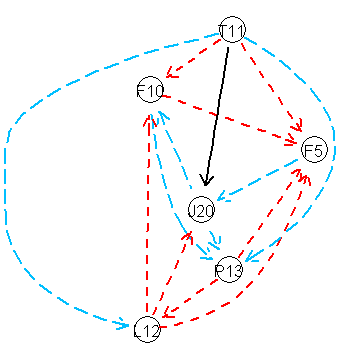

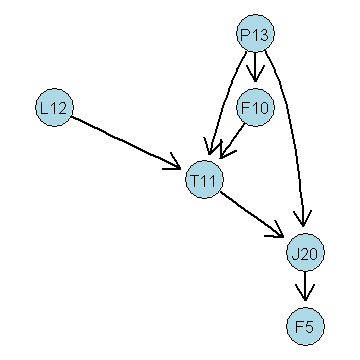

score = BIC, dataset = 3d


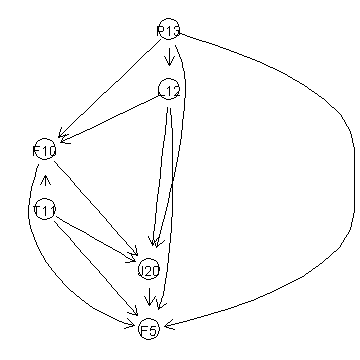

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


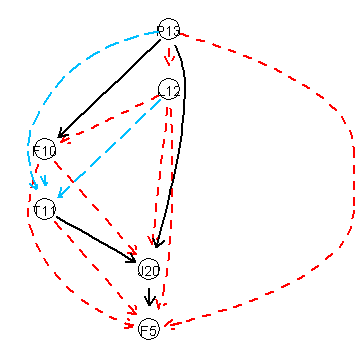

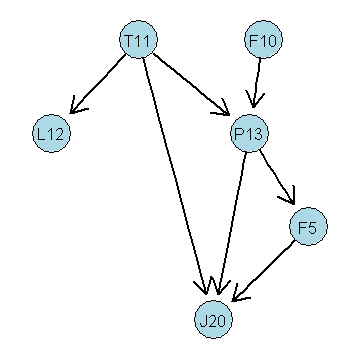

score = BGE, dataset = 3d


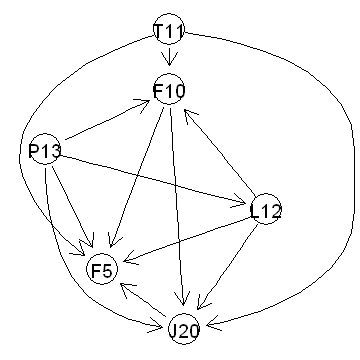

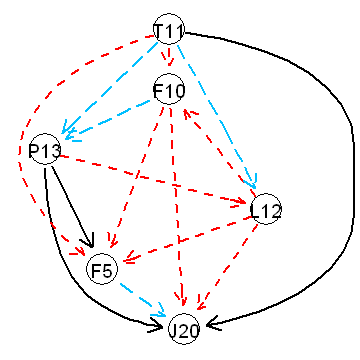

In [141]:
score3d = learn_structure(compressor, "compressor", "3d")

### [Compressor] Comparison of F1 scores across various score-based methods and datasets

In [142]:
rbind(score1a, score1d, score3a, score3d)

,aic,bic,bge
score1a,0.4545455,0.3333333,0.2105263
score1d,0.2857143,0.3,0.1904762
score3a,0.4,0.4,0.4210526
score3d,0.1,0.4,0.3


<hr>

<span style="color:red"><font size="6"><b>8. COMPLETE GRAPH...</b></font></span>

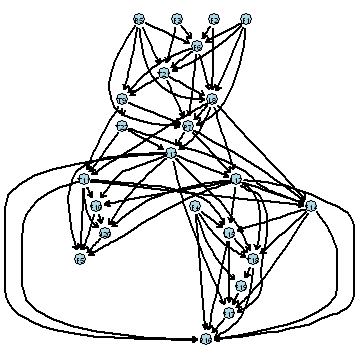

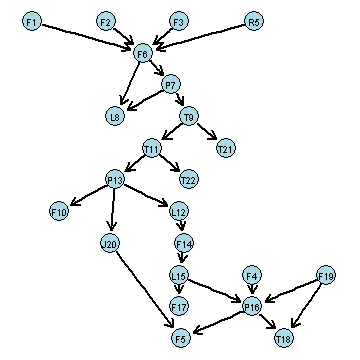

In [146]:
total1 = model2network("[F1][F2][F3][R5][T21|F1:F6:R5:F3][T9|R5:F6:T21][P7|F1:R5:F6:L8:T9:T21][L8|F1:F2:R5:F6:T21][F6|F1:F2:F3:R5][T22|T9][T11|T22:T9:L8][L12|P7:L8:P13][P13|P7:L8:T22][F14|P7:L8:L12:T22:T11][F4][L15|F14:F4:T11:L12][P16|T11:L12:P13:F14:F4:L15:F17:T18][F17|L12:P13:F14:L15:F19][T18|L12:P13:F14:L15:F4][F19|F4:T18][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|J20:F10:L12:P13:T11]")
total2 = model2network("[F1][F2][F3][F4][R5][T21|T9][F6|F1:F2:F3:R5][P7|F6][L8|F6:P7][T9|P7][T22|T11][T11|T9][L12|P13][P13|T11][F14|L12][L15|F14][P16|F4:L15:F19][F17|L15][T18|P16:F19][F19][F10|P13][J20|P13][F5|J20:P16]")
plot_graph(total1)
plot_graph(total2)

### [Complete] Comparing true graph 1 with true graph 2

[1] "True Positive          =  16"
[1] "False Positive         =  57"
[1] "False Negative         =  9"
[1] "Recall (sensitivity)   =  0.64"
[1] "Precision              =  0.219178082191781"
[1] "F1 score               =  0.326530612244898"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


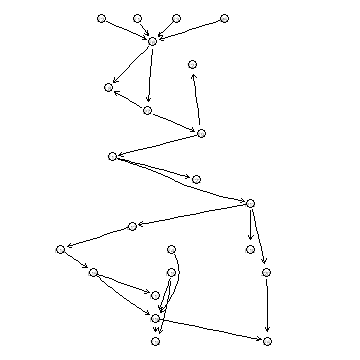

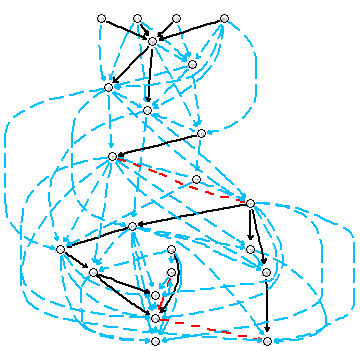

In [147]:
garbage = compare_models(total1, total2)
compare_graph(total2, total1)

### [Complete] Fitting each of the three into linear gaussian model.

In [166]:
gaussian_total1 <- gaussian(total1, read_data("", "1a"))
gaussian_total2 <- gaussian(total2, read_data("", "1a"))

[1] "[F1][F2][F3][F4][R5][F6|F1:F2:F3:R5][T21|F1:F3:F6:R5][L8|F1:F2:F6:R5:T21][T9|F6:R5:T21][P7|F1:F6:L8:R5:T21:T9][T22|T9][P13|L8:P7:T22][T11|L8:T22:T9][L12|L8:P13:P7][F10|L12:P13:T11][F14|L12:L8:P7:T11:T22][J20|F10:L12:P13:T11][L15|F14:F4:L12:T11][F5|F10:J20:L12:P13:T11][T18|F14:F4:L12:L15:P13][F19|F4:T18][F17|F14:F19:L12:L15:P13][P16|F14:F17:F4:L12:L15:P13:T11:T18]"
[1] "[F1][F19][F2][F3][F4][R5][F6|F1:F2:F3:R5][P7|F6][L8|F6:P7][T9|P7][T11|T9][T21|T9][P13|T11][T22|T11][F10|P13][J20|P13][L12|P13][F14|L12][L15|F14][F17|L15][P16|F19:F4:L15][F5|J20:P16][T18|F19:P16]"


### [Complete] Comparing scores across 3 configurations and 4 datasets.

In [182]:
compare_scores_2(total1, total2, "")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-30475.05,-30571.05,-30806.67,-30824.53,-30439.47,-30535.47,-30771.09,-30789.66,-30428.42,-30524.42,-30760.04,-30787.86,-30428.42,-30524.42,-30760.04,-30787.86
-32371.63,-32419.63,-32537.44,-32550.33,-32352.88,-32400.88,-32518.69,-32531.67,-32329.43,-32377.43,-32495.24,-32508.13,-32329.43,-32377.43,-32495.24,-32508.13


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Complete] Learning Bayesian Network structure across 4 datasets using score based methods.

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


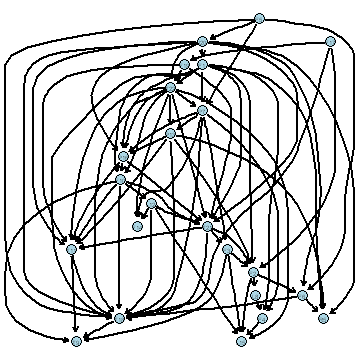

score = AIC, dataset = 1a


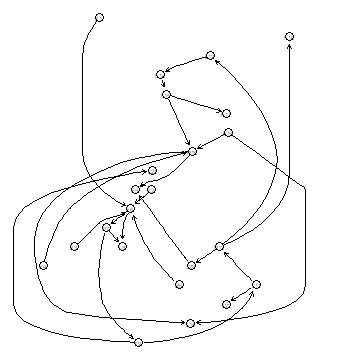

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


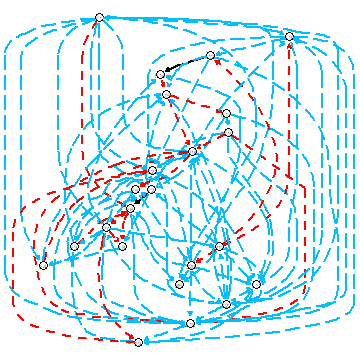

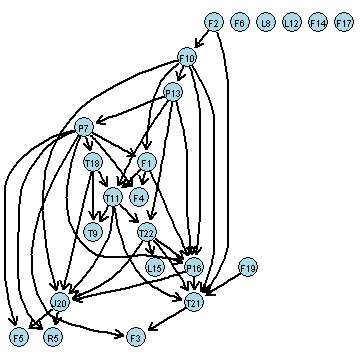

score = BIC, dataset = 1a


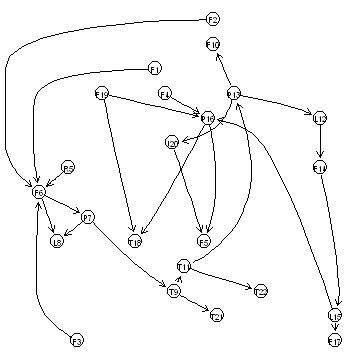

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


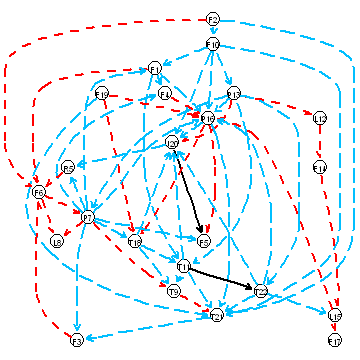

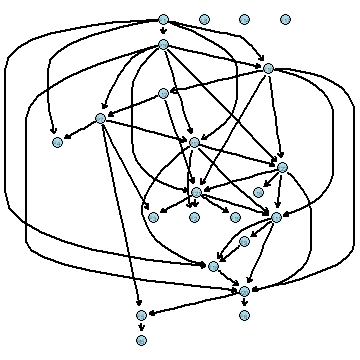

score = BGE, dataset = 1a


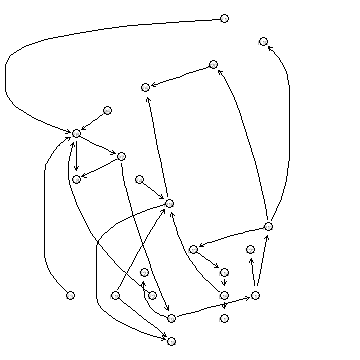

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


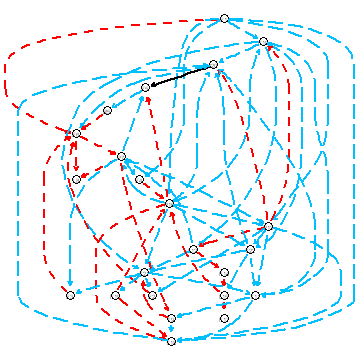

Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

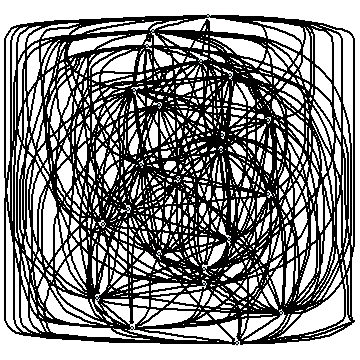

score = LOGLIKE, dataset = 1a


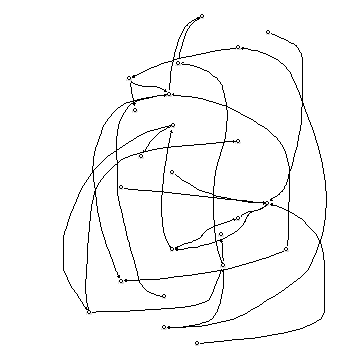

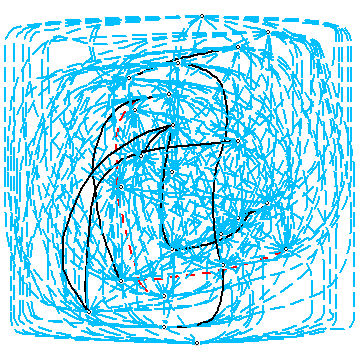

In [189]:
score1a = learn_structure(total2, "", "1a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


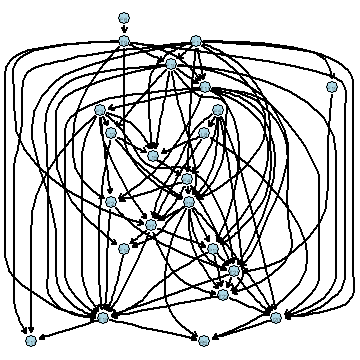

score = AIC, dataset = 1d


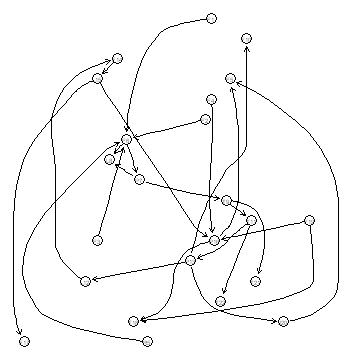

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


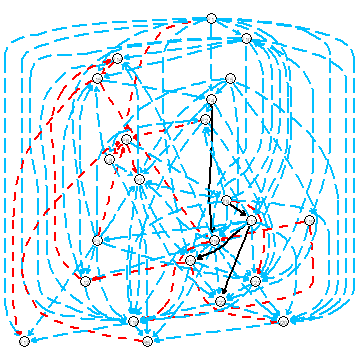

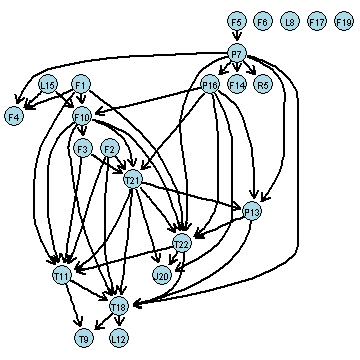

score = BIC, dataset = 1d


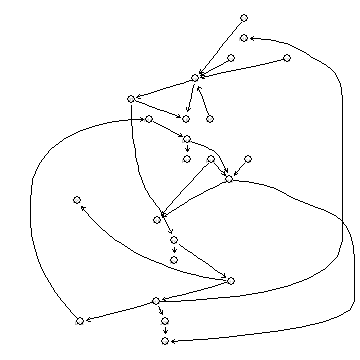

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


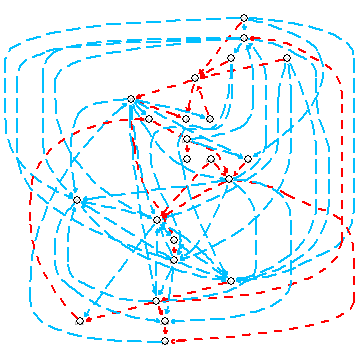

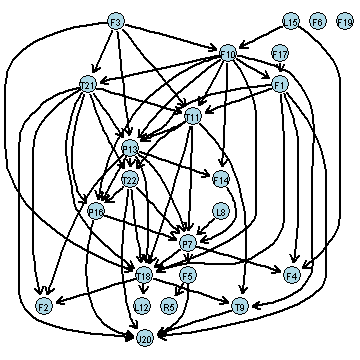

score = BGE, dataset = 1d


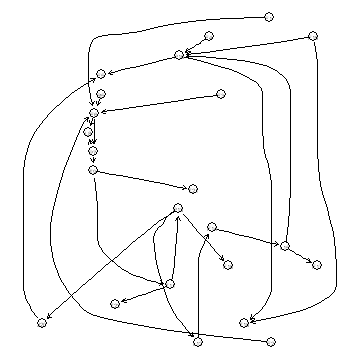

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


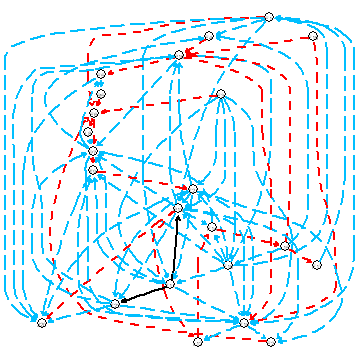

Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

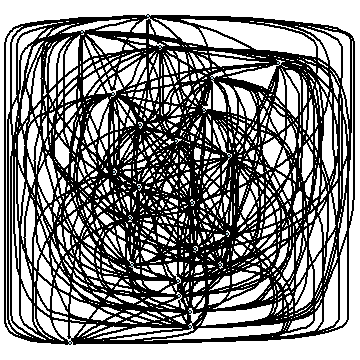

score = LOGLIKE, dataset = 1d


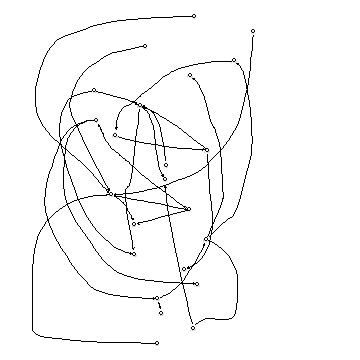

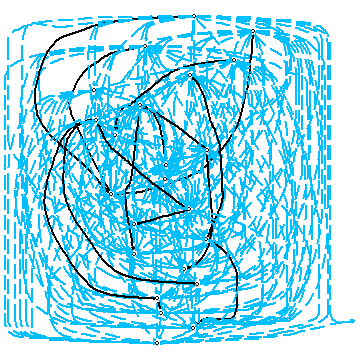

In [190]:
score1d = learn_structure(total2, "", "1d")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


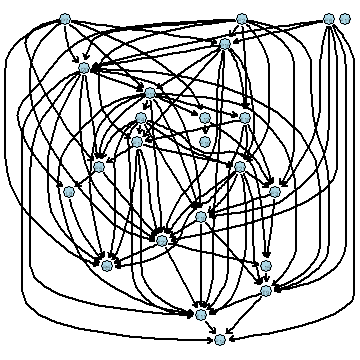

score = AIC, dataset = 3a
Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

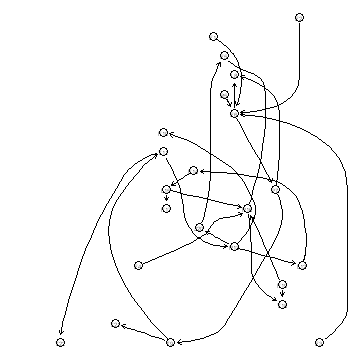

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs
Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

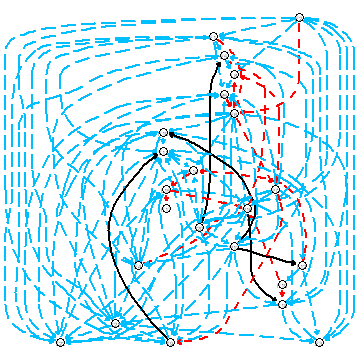

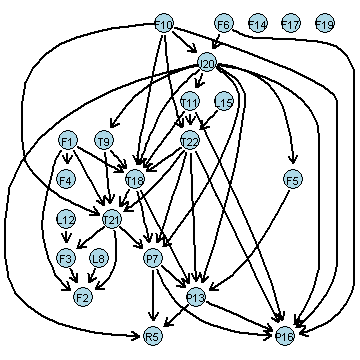

score = BIC, dataset = 3a


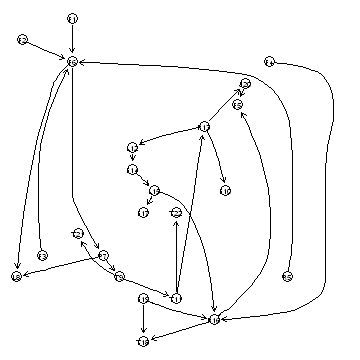

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


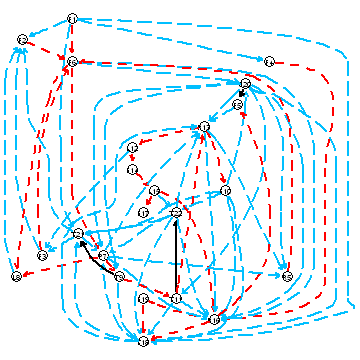

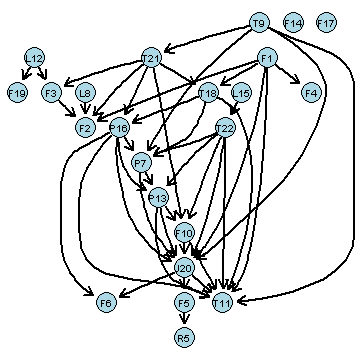

score = BGE, dataset = 3a


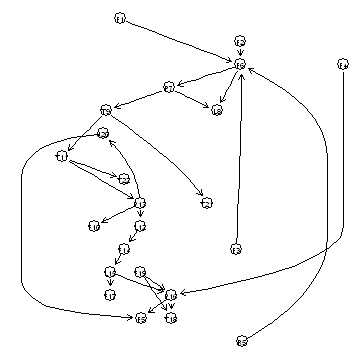

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


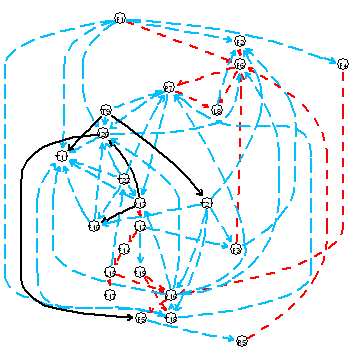

Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

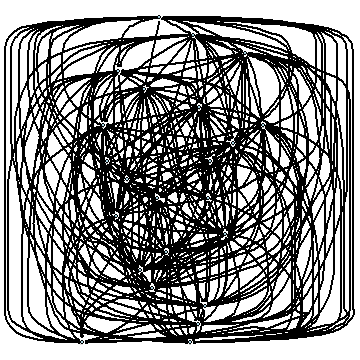

score = LOGLIKE, dataset = 3a


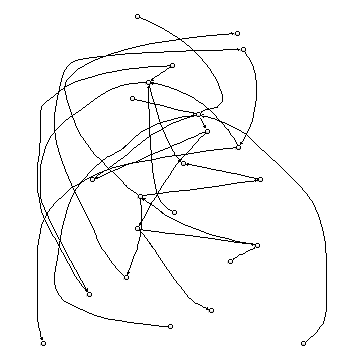

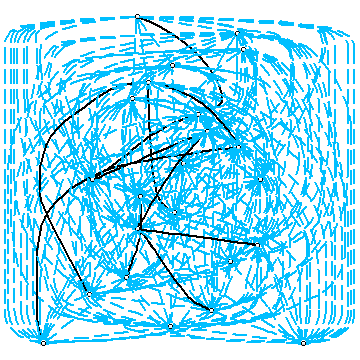

In [191]:
score3a = learn_structure(total2, "", "3a")

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


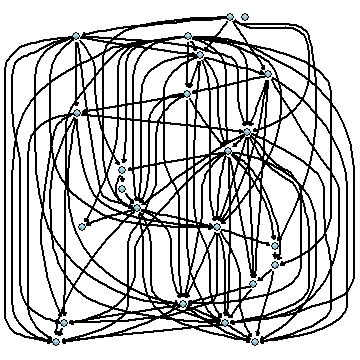

score = AIC, dataset = 3d


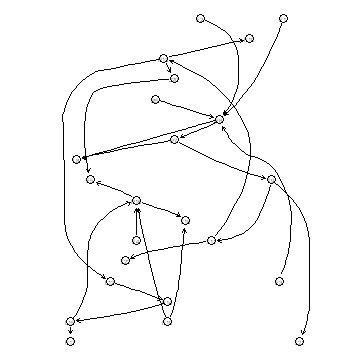

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


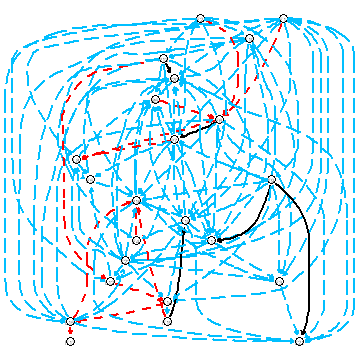

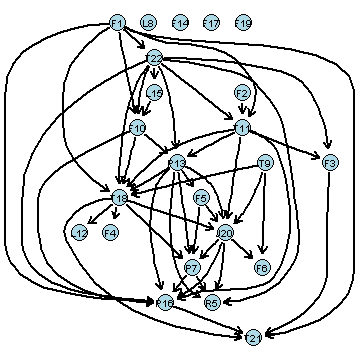

score = BIC, dataset = 3d


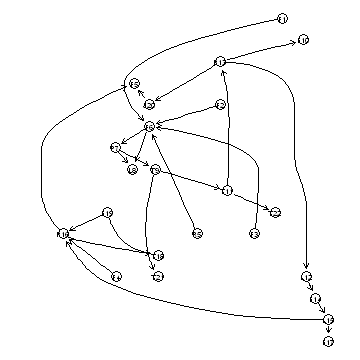

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


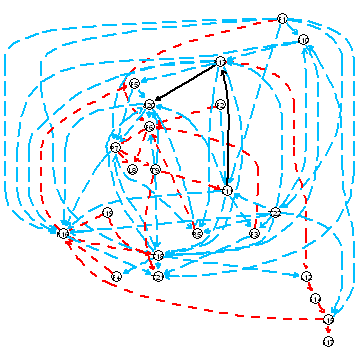

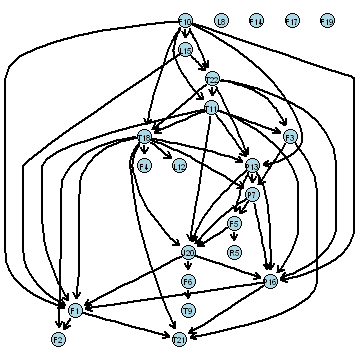

score = BGE, dataset = 3d


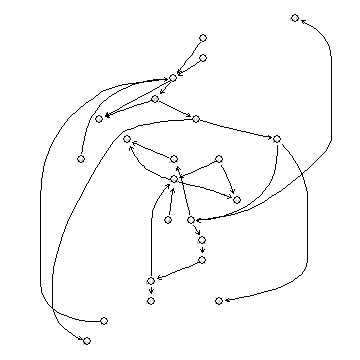

True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


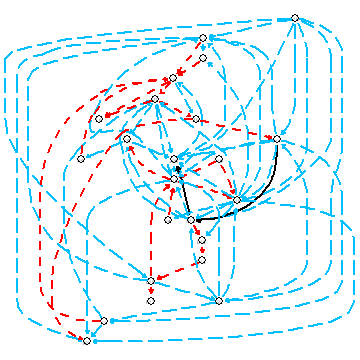

ERROR: Error in apply(arcset, 1, paste, collapse = "~"): dim(X) must have a positive length


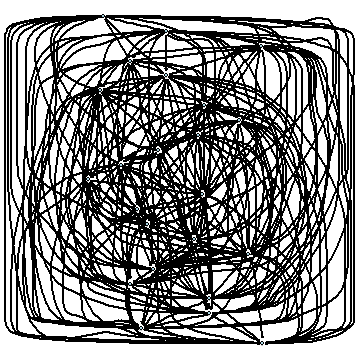

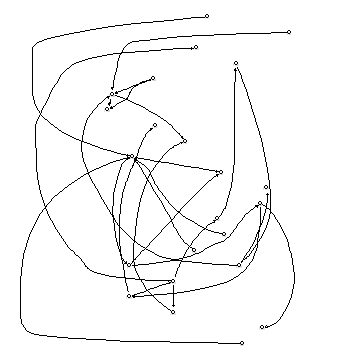

In [192]:
score3d = learn_structure(total2, "", "3d")

### [Complete] Comparison of F1 scores across various score-based methods and datasets

In [193]:
rbind(score1a, score1d, score3a, score3d)

Warning message in rbind(score1a, score1d, score3a, score3d):
"number of columns of result is not a multiple of vector length (arg 4)"

,aic,bic,bge,loglike
score1a,0.03960396,0.06349206,0.02985075,0.07874016
score1d,0.07272727,0,0.04938272,0.1149425
score3a,0.09090909,0.08571429,0.1470588,0.08560311
score3d,0.1,0.4,0.3,0.1


<hr>